This notebook is part of an exploratory analysis of machine learning used to decompose hyperspectral datasets of hybrid perovskite nanoscale materials. Two machine learning models are mainly used in this project: Nonnegative Matrix Factorization (NMF) and Variational Autoencoders (VAEs).

This notebook generates artificial hyperspectral data to test NMF and VAE models and evaluate their accuracy.

**THIS NOTEBOOK IS INCOMPLETE**

**Notebook Six: Using Artificial Data**

# Imports, Functions, and Classes

## Imports

In [1]:
from preprocessing import *

#import PIL
from PIL import ImageFilter
from PIL import Image
from scipy.special import wofz

import nimfa
import sklearn
from sklearn.decomposition import NMF
from sklearn import metrics

import torch; torch.manual_seed(0)
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import pyroved as pv
import pyro.distributions as dist
import pyro
from pyroved.models.base import baseVAE
from pyroved.nets import fcDecoderNet, fcEncoderNet, sDecoderNet
from pyroved.utils import (
    generate_grid, get_sampler, set_deterministic_mode, to_onehot, transform_coordinates)

save_directory = "./png-figures/artificial-data/" # modify to save figures as a specified file extension
file_extension = ".png"

SEM images: f1_img1, f2_img1
CL images: f1_img2, f2_img2
Denoised data: f1_sb_median, f2_sb_median
2D denoised data: f1_denoised_2d, f2_denoised_2d
Example points: f1_x_points, f1_y_points, f2_x_points, f2_y_points
Wavelengths and dimensions: f1_wav, f2_wav, f1_xpix, f1_ypix, f1_zpix, f2_xpix, f2_ypix, f2_zpix


## Functions

### Distributions

In [2]:
# 3 distribution functions: gaussian, lorentzian, and voigt

def gaussian(x, amp1, cen1, sigma1):
    return amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1)**2)))

def lorentzian(x, amp1, cen1, wid1):
    return (amp1 * wid1**2 / ((x - cen1)**2 + wid1**2))

def voigt(x, x0, y0, a, sig, gam):
    return y0 + a * np.real(wofz((x - x0 + 1j * gam) / sig / np.sqrt(2))) / sig / np.sqrt(2 * np.pi)

### VAE Functions

**vae_plot** builds a plot of the latent space dimensions with two or three latent dimensions and plots points corresponding to single pixels in the x and y axes of the original dataset. The point is to show a relationship between different spectral features detected by the autoencoder. Below the plot is an image component of the latent representation of the data.

**spectra_plot** plots each spectrum in the image color mapped according to its value along a specified axis.

**ssvae_plot** plots the latent space and image reconstruction of SSVAE models

**pointfinder_plot** shows every spectrum with a certain x value (along a vertical line in the image).

**spectsig_plot** shows all labeled spectra color mapped according to each class

**ssvae_label_plot** shows the first 180 spectra the SSVAE model assigns to a specified class

**spect_label_plot** plot one spectrum from each class in the labeled data

**custom_spect_label_plot** plot one spectrum from each class in the latent representation of the data

In [4]:
# Plotting pixels containing entire spectra in a latent space and corresponding images
def vae_plot(suptitle, z_mean, xpix, ypix, scalebar_size, save=False):
    
    rows = 2
    columns = len(z_mean[0])
    
    fig = plt.figure(figsize=(4,4))
    fig.suptitle(suptitle, fontsize=10)
    fig.patch.set_facecolor("white")
    
    for i in range(rows):
        for j in range(columns):
            
            if i == 0: # First row
                
                if columns == 2: # 2D Latent space
                    ax = fig.add_subplot(2, 2, j + 1)
                    ax.scatter(z_mean[:, 0], z_mean[:, 1], c=z_mean[:, j], cmap=cmap,
                            ec='black', lw=0.1, alpha=0.6, s=2)
                    ax.tick_params(axis='both', which='major', labelsize=4, direction='out', 
                               length=2, width=0.5)
                    
                else: # 3D Latent space
                    ax = fig.add_subplot(2, 3, j + 1, projection='3d')
                    ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2], 
                            c=z_mean[:, j], cmap=cmap,
                            ec='black', lw=0.05, alpha=0.5, s=2)
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                    ax.zaxis.set_ticklabels([])
                    ax.set_xlabel("X", size=5, labelpad=-15)
                    ax.set_ylabel("Y", size=5, labelpad=-15)
                    ax.set_zlabel("Z", size=5, labelpad=-15)
                    if j == 0:
                        ax.view_init(30, -85) 
                    elif j == 1:
                        ax.view_init(30, -40)
                    elif j == 2:
                        ax.view_init(30, 5)
                
                if j == 0:
                    ax.set_title('Latent Space', size=7)
            
            if i == 1: # Second row
                
                if columns == 2: # 2D Latent Space
                    img = fig.add_subplot(2, 2, j+3)
                else: # 3D Latent Space
                    img = fig.add_subplot(2, 3, j+4)
                    
                img.imshow(z_mean[:,j].reshape(ypix, xpix), cmap=cmap)
                img.set_xticks([])
                img.set_yticks([])
                
                if j == (columns-1): # Add scalebar to bottom right image
                    scalebar = AnchoredSizeBar(img.transData, scalebar_size, " ", 
                            "lower right", pad=0.2, color='#F2F2F2', frameon=False,
                                               size_vertical=3, label_top=True)
                    img.add_artist(scalebar)
    
    if save:
        fig.savefig(save_directory + "unsupervised-vae/" + suptitle + file_extension)
        
# Spectra Plot (for determining latent dimensions)
def spectra_plot(suptitle, img, array, xpix, ypix, wav, save=False):
    
    n = xpix*ypix # total number of spectra
    cmap = mpl.colormaps['viridis'](np.linspace(0,1,n)) # create colormap
    fig = plt.figure(figsize=(6,3))
    fig.suptitle(suptitle, fontsize=10)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot()
    ax.set_prop_cycle('color', list(cmap)) # colormaps each spectra from first to last in array
    ax.tick_params(axis='both', which='major', labelsize=5, direction='out', length=2, width=0.5)
    plt.xlim(short_wav - 5, long_wav + 5)
    #ax.set_xticks([500, 750])
    #ax.set_xticklabels([])
    #plt.yscale('log')
    
    for i in array:
        ax.plot(wav, img[:,i[0],i[1]], lw=0.03, alpha=0.5)
    
    if save:
        fig.savefig(save_directory + "unsupervised-vae/" + suptitle + file_extension)

        
# SEMI-SUPERVISED VAE

# Plot the latent space and image reconstruction of SSVAE models
def ssvae_plot(suptitle, z_mean, z_labels, xpix, ypix, scalebar_size, save=False):
    
    rows = 2
    columns = 1
    
    cmap = mpl.colormaps['viridis']
    fig = plt.figure(figsize=(4,4))
    fig.suptitle(suptitle, fontsize=10)
    gs = GridSpec(rows, columns)
    #fig.patch.set_facecolor('#00000000')
    fig.patch.set_facecolor('white')
    
    for i in range(rows):
        column_count = 0
        for j in range(columns):
            if i == 0:
                ax = fig.add_subplot(gs[0,column_count])
                ax.scatter(z_mean[:,0], z_mean[:,1], c=z_labels, cmap=cmap,
                        ec='black', lw=0.05, alpha=0.6, s=2)
                #ax.tick_params(axis='both', labelsize=10)
                ax.set_xticks([])
                ax.set_yticks([])
                
            if i == 1:
                img = fig.add_subplot(gs[1,column_count])
                img.imshow(z_labels.reshape(ypix, xpix), cmap=cmap)
                img.set_xticks([])
                img.set_yticks([])
                
                if column_count == (columns-1):
                    scalebar = AnchoredSizeBar(img.transData, scalebar_size, " ", 
                            "lower right", pad=0.3, color='#F2F2F2', frameon=False,
                                               size_vertical=3, label_top=True)
                    img.add_artist(scalebar)

            column_count += 1
    
    if save:
        fig.savefig(save_directory + "semi-supervised-vae/" + suptitle + file_extension)

# Function to plot every spectrum with a certain x value (along a vertical line in the image)
def pointfinder_plot(img, x_pt, ypix, wav):
    
    rows = ypix
    columns = 1
    fig = plt.figure(figsize=(4, rows))
    
    for i in range(rows):

        ax = fig.add_subplot(rows, columns, i + 1)
        ax.plot(wav, img[:, i, x_pt], c=color[i], lw=2)
        ax.text(220, 350, str([i, x_pt]), fontsize=5)
        ax.set_xticks([])
        ax.set_yticks([])   

    plt.show()

# Plot all spectra in each of the 4 classes
def spectsig_plot(suptitle, img, pts, wav, save=False):
    
    rows = len(pts[0])
    columns = 4
    gs = GridSpec(rows, columns)
    gs.update(wspace=0, hspace=0)

    figsize = (columns*2, rows)
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor("white")
    fig.suptitle(suptitle, fontsize=20)
    #fig.subplots_adjust(top=0.95, bottom=0.1)

    row_count = 0
    for i in range(rows):

        column_count = 0
        for j in range(columns):

            fig_plt = fig.add_subplot(gs[i,j])
            fig_plt.plot(wav, img[pts[j][i][0],pts[j]
                                  [i][1],:], c=cmap_list[j], lw=1)
            plt.xlim(short_wav - 5, long_wav + 5) # Cropping the spectra shown in the plot
            #fig_plt.tick_params(axis='both', direction='out', length=12, width=4)
            fig_plt.set_xticks([])
            fig_plt.set_yticks([])
            
            #if column_count == 0:
                #fig_plt.set_yticks([1000])
                #fig_plt.set_yticklabels([])
                #fig_plt.tick_params(axis='y', direction='out', length=12, width=4)
            
            #if row_count == rows-1:
                #fig_plt.set_xticks([400-short_wav, 750-long_wav])
                #fig_plt.set_xticklabels([])
                #fig_plt.tick_params(axis='x', direction='out', length=12, width=4)

            column_count += 1

        row_count += 1
    
    if save:
        fig.savefig(save_directory + "semi-supervised-vae/" + suptitle + file_extension)
    plt.show()
    
# This plot shows the first 180 spectra the SSVAE model assigns to a specified class
def ssvae_label_plot(img, pts, wav, starting_index=0, save=False):
    
    rows = 180
    #rows = len(pts)
    columns = 1
    fig = plt.figure(figsize=(4, rows))
    fig.patch.set_facecolor("white")
    #fig.suptitle(suptitle, fontsize=30)
    gs = GridSpec(rows, columns)
    
    row_count = 0
    for i in range(starting_index, starting_index + rows):

        fig_plt = fig.add_subplot(gs[row_count,0])
        fig_plt.plot(wav, img[:, pts[i,0], pts[i,1]], 
                     c=color[row_count], lw=3)
        plt.xticks([])
        plt.yticks([])
        #plt.text(220,350,str((int(pts[i][0]),int(pts[i][1]))))
        plt.text(0, 0, str(i))
        row_count += 1

    #gs.tight_layout(fig, rect=[0,0.03,1,0.95])
    if save:
        fig.savefig(save_directory + "semi-supervised-vae/" + suptitle + file_extension)
    plt.show()

# Plot one spectrum from each class in the labeled data
def spect_label_plot(suptitle, img, pts, wav, save=False):
    
    rows = 1
    columns = 4
    gs = GridSpec(rows, columns)
    gs.update(wspace=0,hspace=0.2)

    figsize = (columns*4, rows*3)
    fig = plt.figure(figsize=figsize)
    fig.suptitle(suptitle, size = 20)
    fig.patch.set_facecolor("white")
    #fig.patch.set_facecolor('#00000000')
    #fig.suptitle(suptitle, fontsize=30)
    #fig.subplots_adjust(top=0.95, bottom=0.1)

    row_count = 0
    for i in range(rows):

        column_count = 0
        for j in range(columns):

            fig_plt = fig.add_subplot(gs[i,j])
            fig_plt.plot(wav, img[:,pts[j][i][0],pts[j][i][1]], c=cmap_list[j], lw=3)
            #plt.text(300, 370, str(column_count))
            #fig_plt.set_title(method_names[row_count] + point_names[column_count])
            #fig_plt.tick_params(color=color[j])
            plt.xlim(short_wav - 5, long_wav + 5) # Cropping the spectra shown in the plot
            #fig_plt.tick_params(axis='both', direction='out', length=12, width=4)
            #fig_plt.set_xticks([400, 550, 750])
            fig_plt.set_yticks([])
            fig_plt.set_xticks([])

            column_count += 1

        row_count += 1
    
    if save:
        fig.savefig(save_directory + "/semi-supervised-vae/" + suptitle + file_extension)
    plt.show()

# Plot one spectrum from each class in the latent representation of the data
def custom_spect_label_plot(suptitle, img, pts, wav, save=False):
    
    rows = 1
    columns = 4
    gs = GridSpec(rows, columns)
    gs.update(wspace=0,hspace=0.2)

    figsize = (columns*4, rows*3)
    fig = plt.figure(figsize=figsize)
    #fig.patch.set_facecolor("#00000000")
    fig.patch.set_facecolor("white")
    fig.suptitle(suptitle, fontsize=20)
    #fig.subplots_adjust(top=0.95, bottom=0.1)

    row_count = 0
    for i in range(rows):

        column_count = 0
        for j in range(columns):

            fig_plt = fig.add_subplot(gs[i, j])
            fig_plt.plot(wav, img[:, pts[j][0], pts[j][1]], c=cmap_list[j], lw=3)
            #plt.text(300, 370, str(column_count))
            #fig_plt.set_title(method_names[row_count] + point_names[column_count])
            #fig_plt.tick_params(color=color[j])
            plt.xlim(short_wav, long_wav) # Cropping the spectra shown in the plot
            fig_plt.tick_params(axis='both', direction='out', length=6, width=2)
            #fig_plt.set_xticks([400, 750])
            fig_plt.set_xticks([])
            fig_plt.set_yticks([])
            #fig_plt.set_xticklabels([])
            
            #if column_count == 0:
                #fig_plt.set_yticks([1000])
                #fig_plt.set_yticklabels([])
                #fig_plt.tick_params(axis='y', direction='out', length=12, width=4)
            
            #if row_count == rows-1:
                #fig_plt.set_xticks([400-short_wav, 750-long_wav])
                #fig_plt.set_xticklabels([])
                #fig_plt.tick_params(axis='x', direction='out', length=12, width=4)

            column_count += 1

        row_count += 1
    
    if save:
        fig.savefig(save_directory + "/semi-supervised-vae/" + suptitle + file_extension)
    plt.show()

## Hyperspectral Image Class

In [3]:
class HSI:

    # Initialize the HSI
    def __init__(self, img, dist1, dist2, dist3, zpix, ypix, xpix, 
                 filter_type=None, filter_strength=0, noise=0):
    
        self.filter_type = filter_type
        self.filter_strength = filter_strength
        
        # Add image filter
        if self.filter_type == "Gaussian" or "gaussian":
            self.im = img.filter(ImageFilter.GaussianBlur(radius = self.filter_strength))

        if self.filter_type == "Box" or "box":
            self.im = img.filter(ImageFilter.BoxBlur(radius = self.filter_strength))

        if self.filter_type == None or "None" or "none":
            self.im = img
        
        # Initialize noise type
        if noise == 0:
            self.noise = 0
            
        elif noise == 1:
            self.noise = np.random.normal(0,.37,zpix)

        elif noise == 2:
            self.noise = np.random.normal(0,1.85,zpix)

        elif noise ==3 :
            self.noise = np.random.normal(0,3.5,zpix)
        
        # Add noise to distributions
        self.dist1 = dist1 + self.noise
        self.dist2 = dist2 + self.noise
        self.dist3 = dist3 + self.noise
        
        # Create the HSI
        r, g, b = self.im.split()
        zero = r.point(lambda _ : 0) # create xpix by ypix array of zeros

        red_merge = Image.merge("RGB", (r, zero, zero))
        green_merge = Image.merge("RGB", (zero, g, zero))
        blue_merge = Image.merge("RGB", (zero, zero, b))
        red_array = np.asarray(red_merge)[:, :, 0]
        green_array = np.asarray(green_merge)[:, :, 1]
        blue_array = np.asarray(blue_merge)[:, :, 2]

        red = normalize(red_array.flatten()).tolist()
        blue = normalize(blue_array.flatten()).tolist()
        green = normalize(green_array.flatten()).tolist()

        for i in range(len(red)):
            red[i] = red[i] * self.dist1

        for i in range(len(green)):
            green[i] = green[i] *self.dist2

        for i in range(len(blue)):
            blue[i] = blue[i] * self.dist3

        hyper = []
        for i in range(len(blue)):
            idx = red[i] + green[i] + blue[i]
            hyper.append(idx)

        hyper = np.asarray(hyper).reshape(xpix, ypix, zpix)
        hyper = np.swapaxes(hyper, 0, 2)
        hyper = np.rot90(hyper, k=3, axes=(1, 2))
        hyper = np.flip(hyper, axis=2)
        self.hyper = hyper
                
        
    # Original image  
    def img(self):
        plt.imshow(self.im)


    # Image at certain band
    def hyper_img(self, band):
        return(plt.imshow(self.hyper[:, :, band], cmap = "viridis"))


    # Spectra at certain pixel
    def hyper_band(self, x, y, color):
        
        self.color = str(color)
        
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.plot(self.hyper[:, y, x], color=self.color)
        
        return fig

# Generating Artificial Data

## Reading Blazers Image

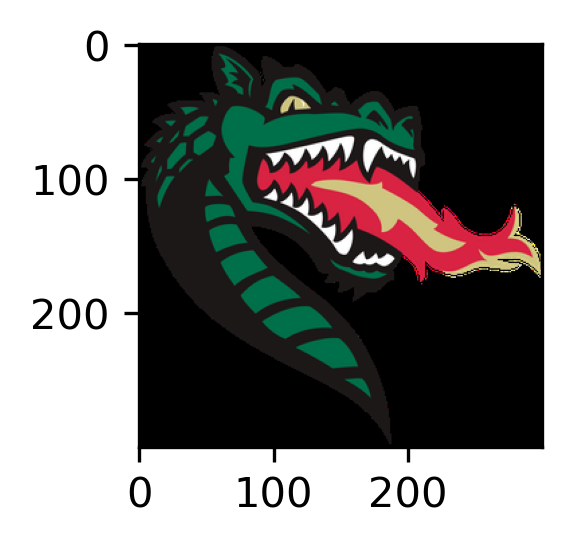

In [4]:
# Define image dimensions
zpix = 1024
ypix = 300
xpix = 300

rgba = Image.open(r"png-figures/uab-blazers.png")
rgba = rgba.resize((xpix, ypix), Image.Resampling.LANCZOS)
#rgba = rgba.transpose(method=Image.FLIP_LEFT_RIGHT)
rgb = rgba.convert('RGB')
gray = rgb.convert('L')

# Display image
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(rgb)
plt.tight_layout()

## Create HSI

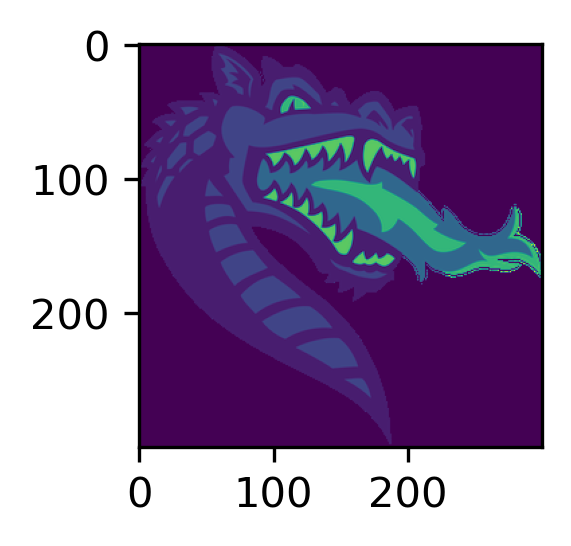

In [6]:
# distributions
x = np.linspace(0, zpix, zpix)
red_gaussian = gaussian(x, 8000, 775, 100) 
green_lorentzian = lorentzian(x, 100, 450, 50)
blue_voigt = voigt(x, 75, 0, 4000, 75, 1) 

# HSI without noise
hsi1 = HSI(rgb, red_gaussian, green_lorentzian, blue_voigt, zpix, ypix, xpix)
hsi1 = hsi1.hyper

# HSI with Gaussian noise
hsi = HSI(rgb, red_gaussian, green_lorentzian, blue_voigt, zpix, ypix, xpix, 
           filter_type='Gaussian', filter_strength=1, noise=2)
hsi = hsi.hyper

#hsi.hyper_band(100, 200, color[0])
#plt.show()

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(hsi[600, :, :])
plt.tight_layout()

## Plot HSI

### Plot Code

In [43]:
def artificial_data_plot(suptitle, hsi, pts, save=False):
    
    # Create figure
    fig, axes = plt.subplots(figsize=(10, 12))
    fig.suptitle(suptitle, fontsize=20)
    rows = 3 
    columns = 2
    gs = GridSpec(rows, columns)
    gs.update(wspace=0.1,hspace=0.1)
    
    title_fontsize = 7
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.spines["bottom"].set_visible(False)
    axes.spines["left"].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
    count = 0
    for i in range(rows):

        # img
        ax = fig.add_subplot(gs[i, 0])
        ax.imshow(hsi[pts[i][0][0], :, ], cmap=cmap)
        ax.set_title("Wavelength: " + str(pts[i][0][0]), fontsize=title_fontsize)
        ax.plot(pts[i][0][2], pts[i][0][1], "X", markersize=5, c=color[count])
        ax.plot(pts[i][1][2], pts[i][1][1], "X", markersize=5, c=color[count + 1])
        ax.set_xticks([])
        ax.set_yticks([])

        # plt
        ax = fig.add_subplot(gs[i, 1])
        ax.plot(hsi[:, pts[i][0][1], pts[i][0][2]], lw=2, c=color[count])
        ax.plot(hsi[:, pts[i][1][1], pts[i][1][2]], lw=2, c=color[count + 1])
        ax.axvline(x=pts[i][0][0], ls="--", c="black", lw=2)
        
        count += 2
        
    if save:
        fig.savefig(save_directory + suptitle + file_extension)
        
        
# list of 3 sets of red and blue points ordered [z, y, x]
pts = [[[230, 150, 150], [230, 150, 225]], [[440, 45, 280], [440, 45, 122]], 
       [[800, 145, 40], [800, 145, 60]]]

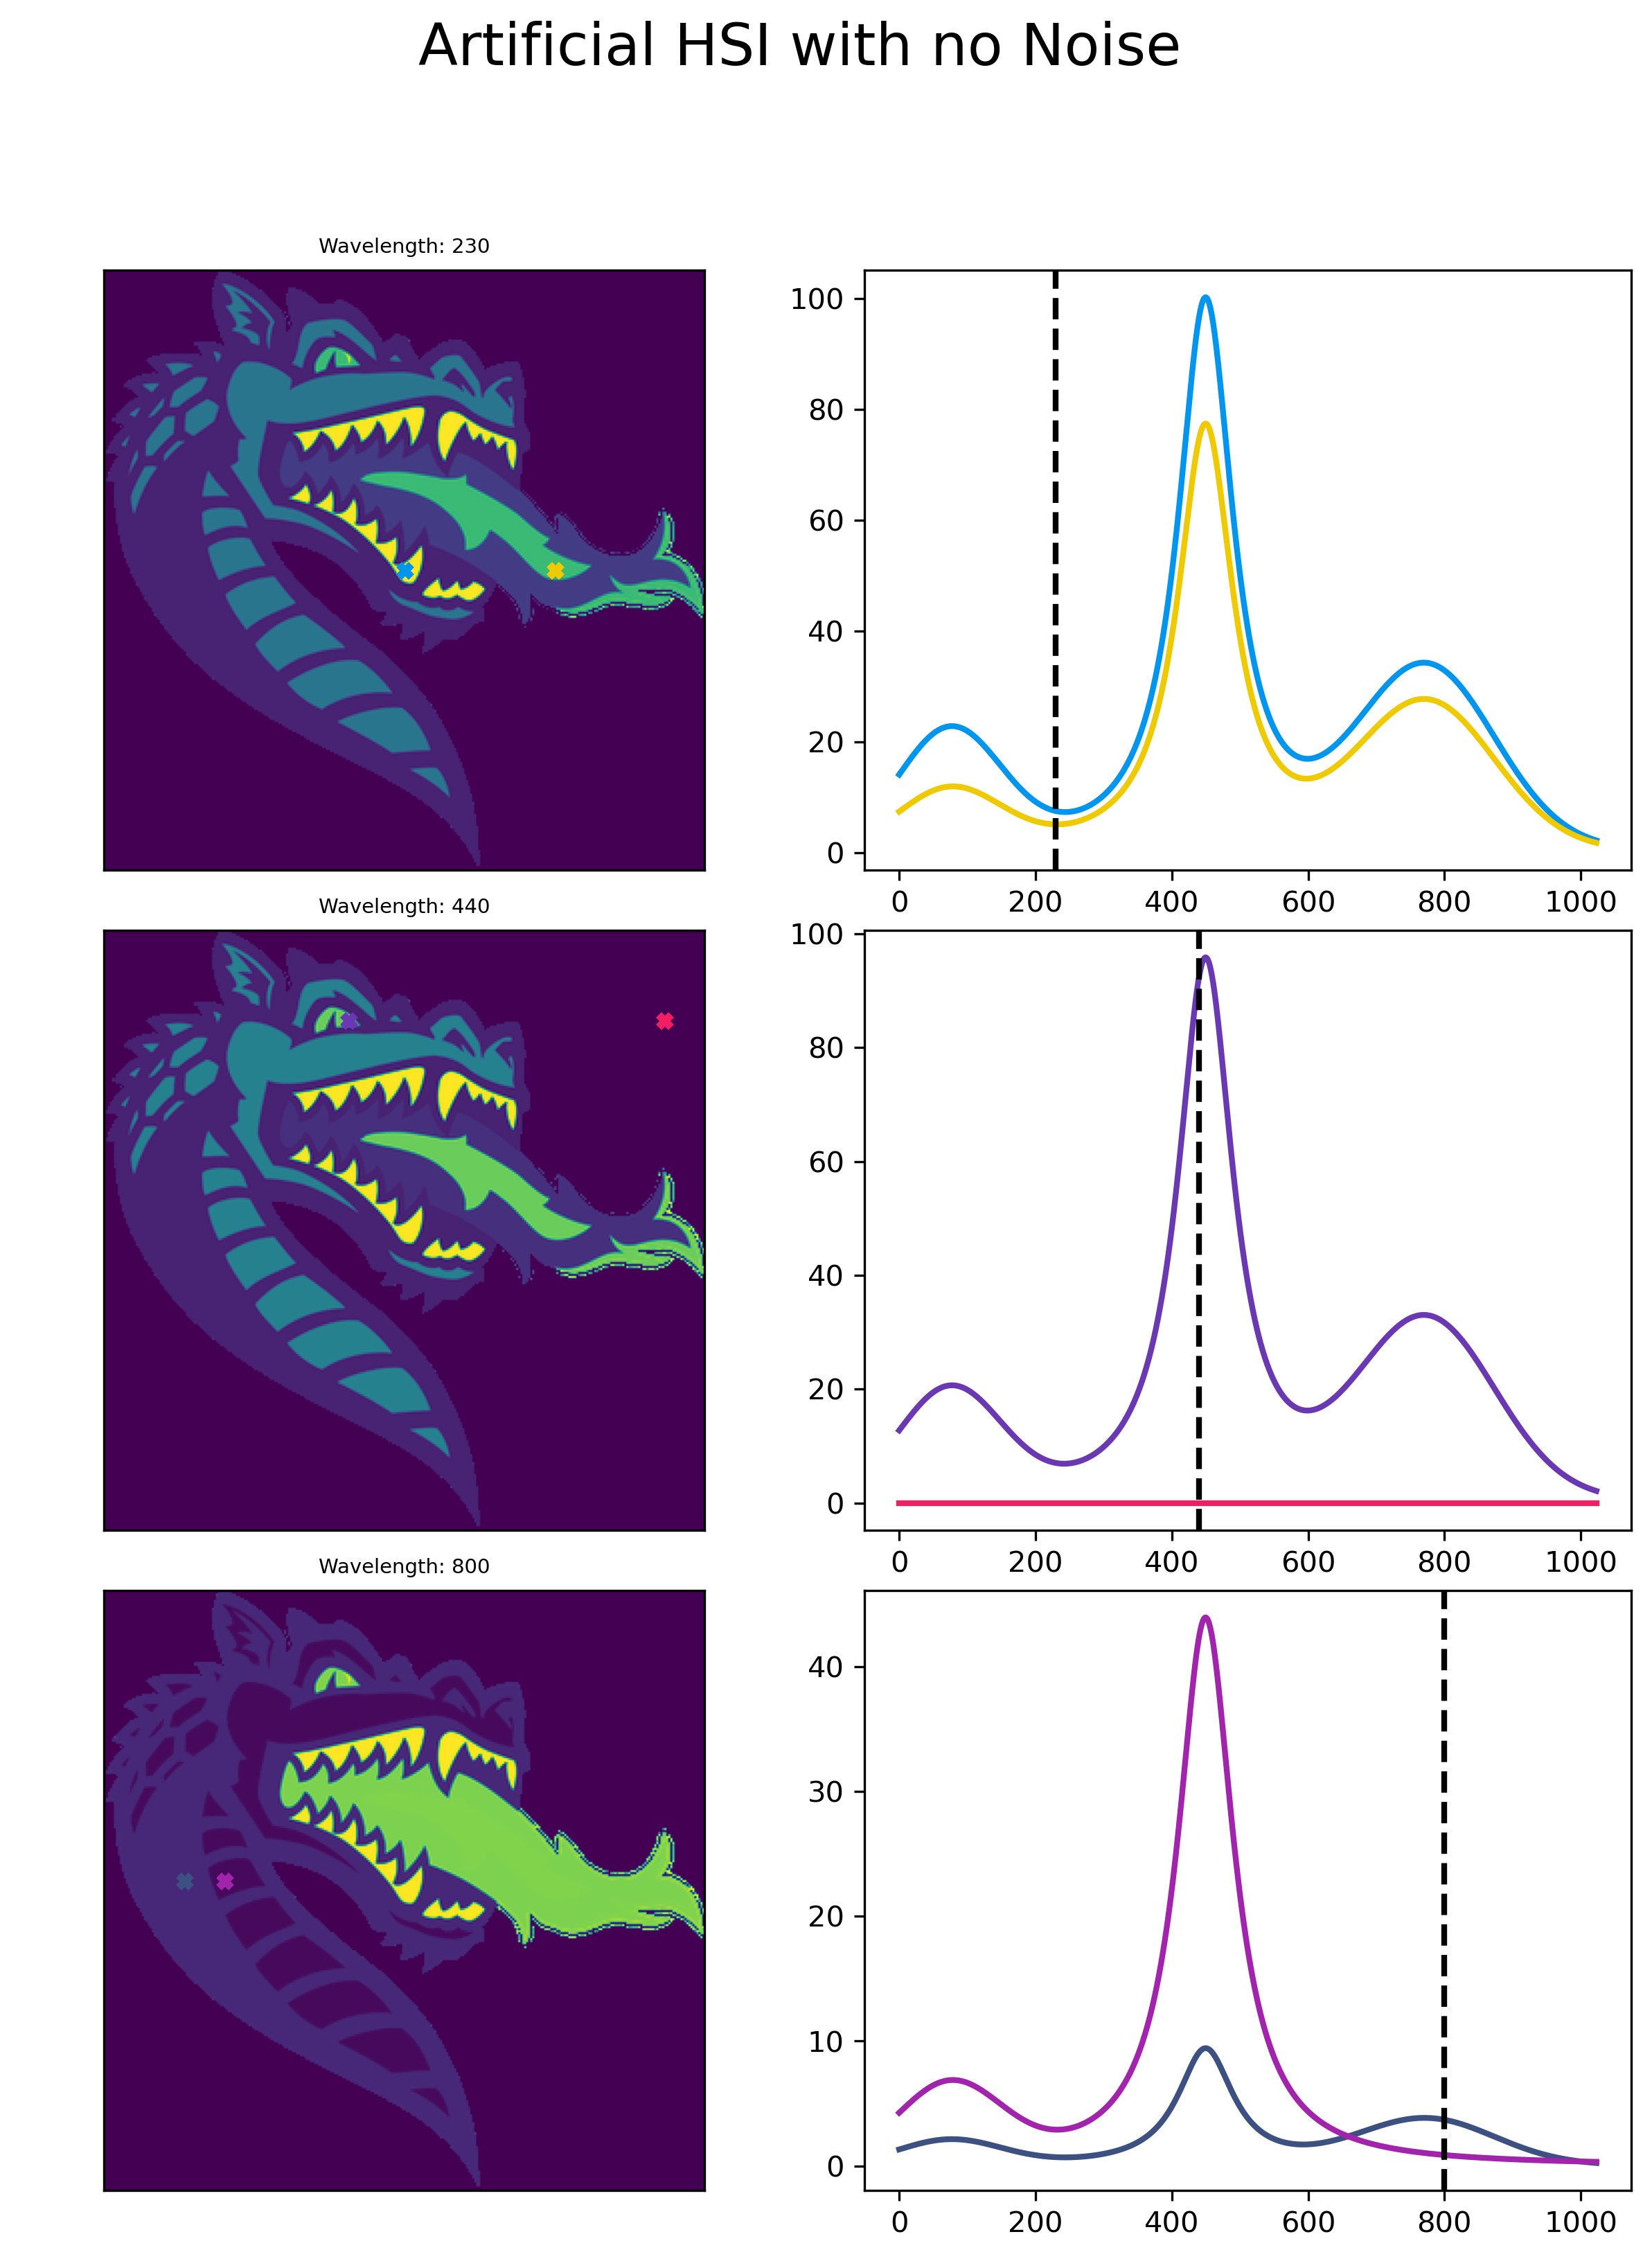

In [44]:
artificial_data_plot("Artificial HSI with no Noise", hsi1, pts)

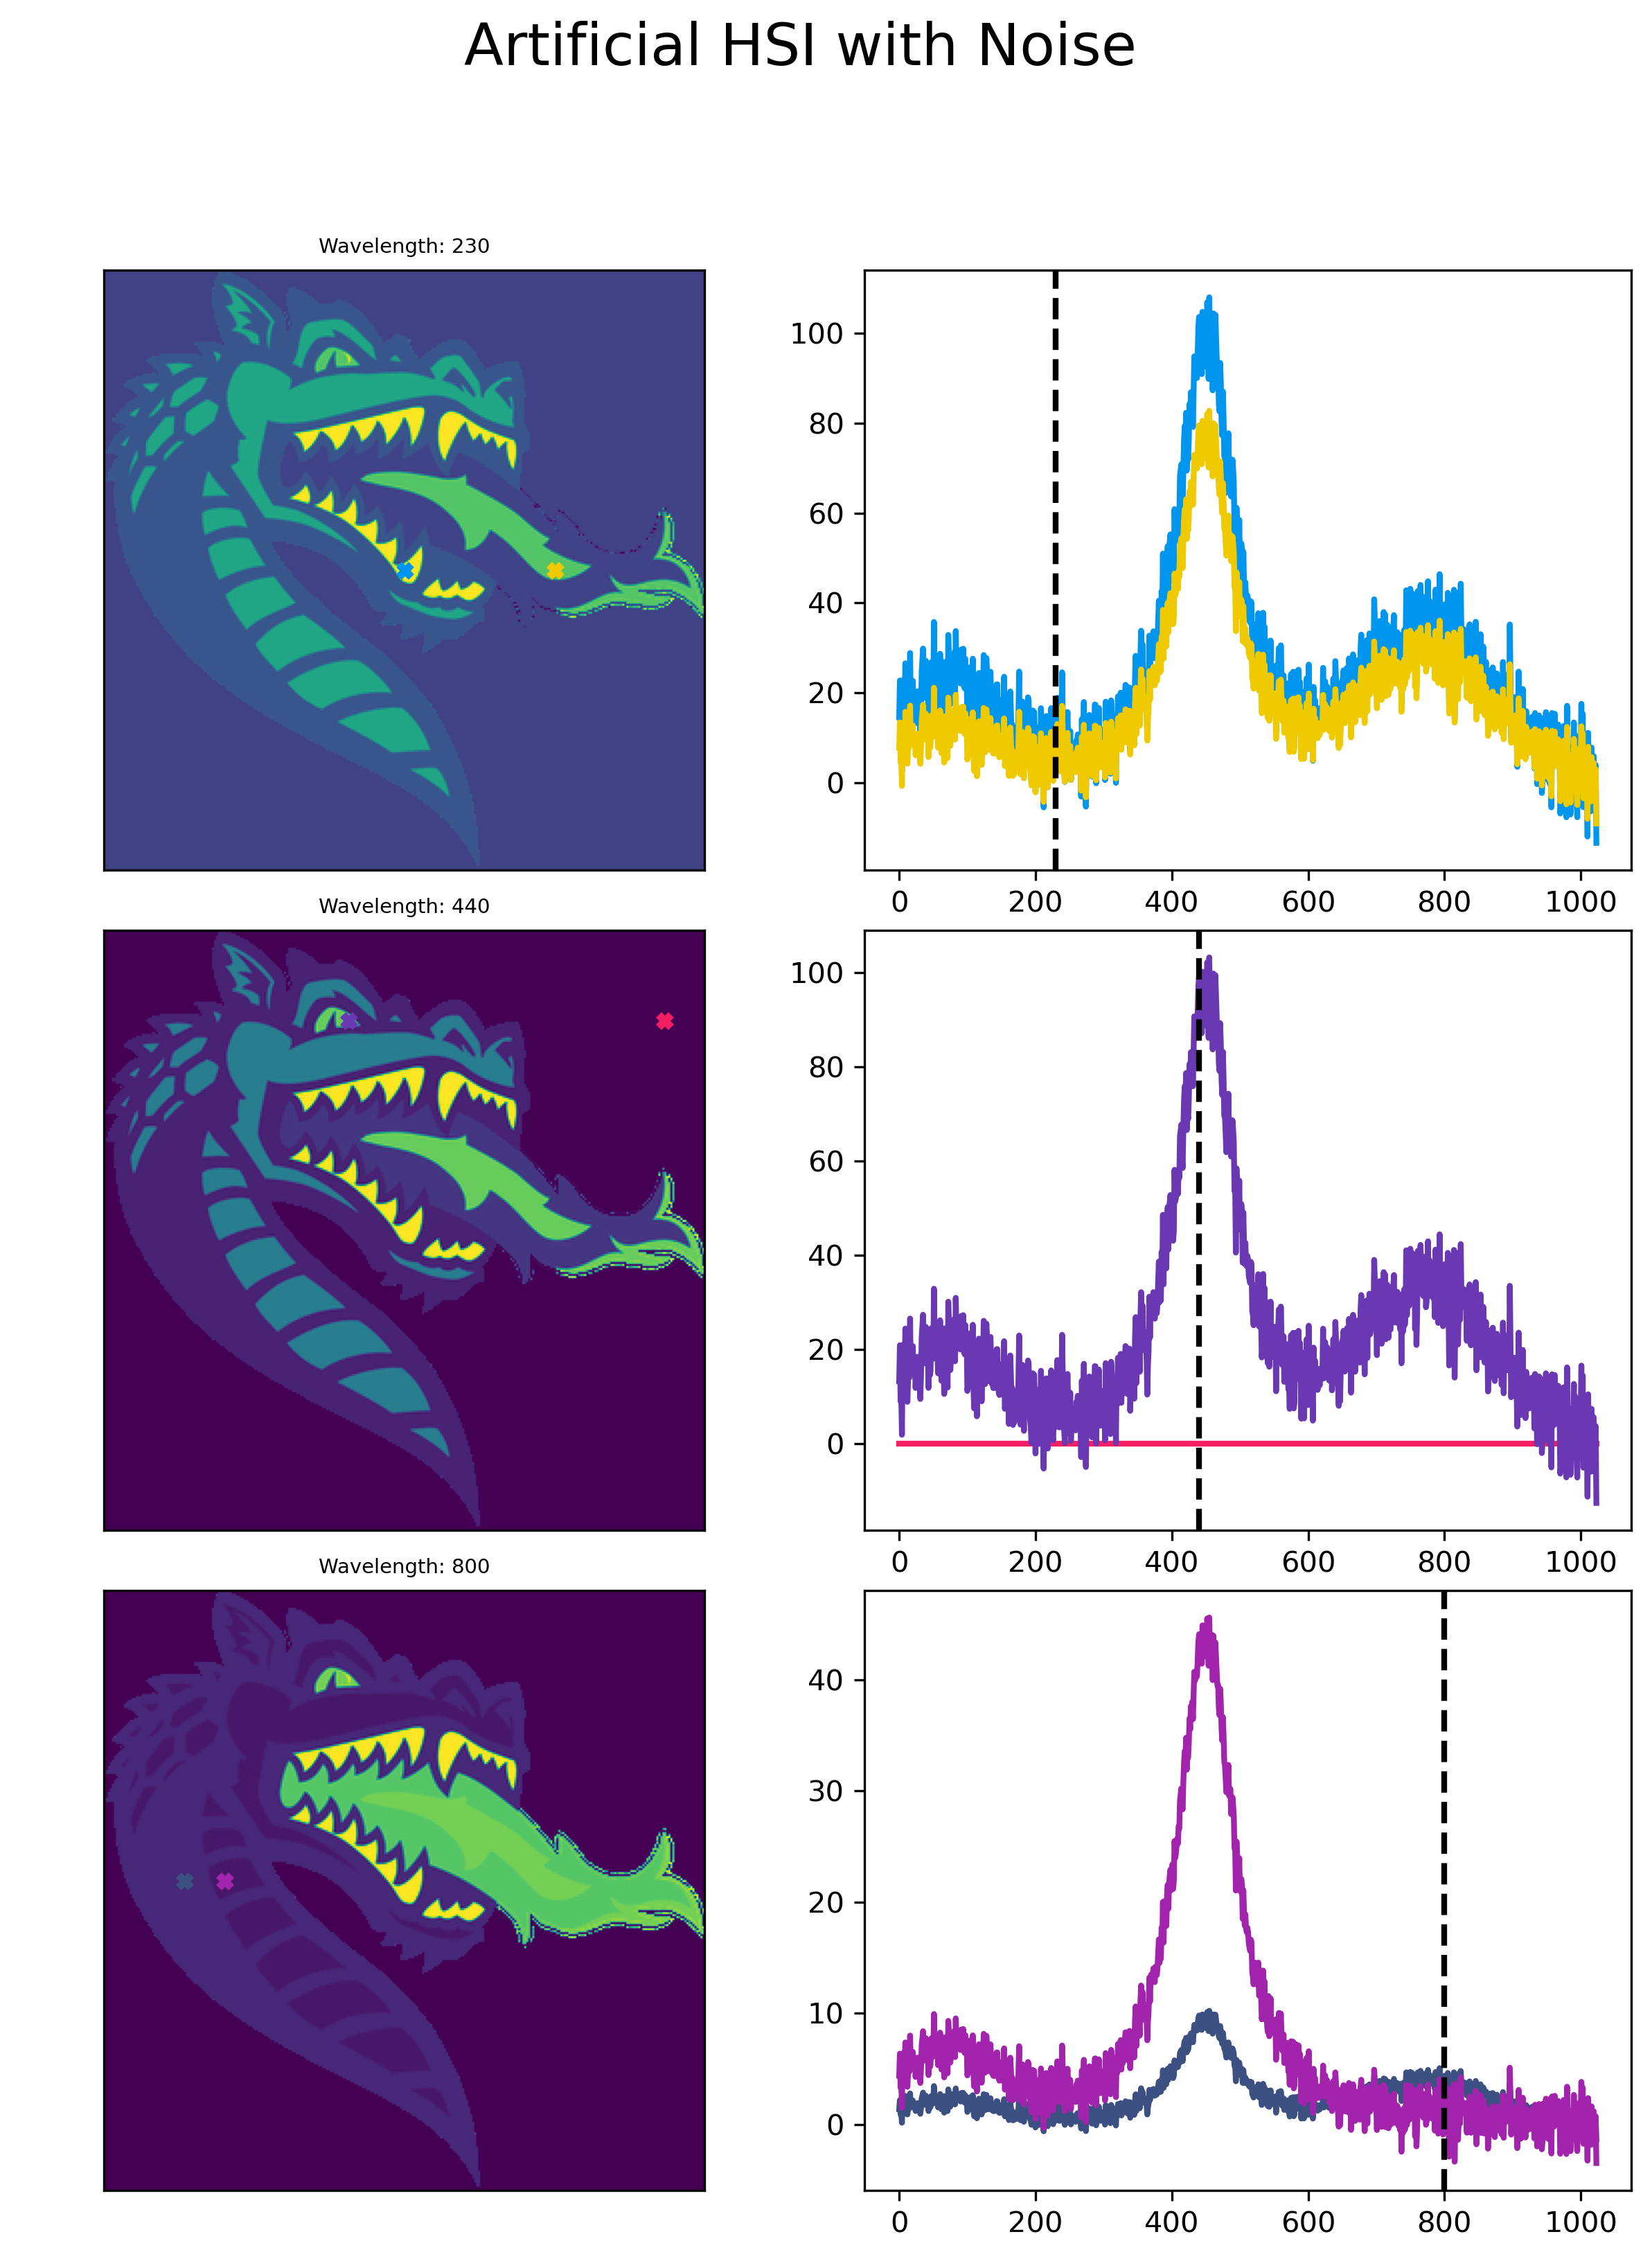

In [45]:
artificial_data_plot("Artificial HSI with Noise", hsi, pts)

#### Extra

In [110]:
# Just in case
def artificial_data_plot(suptitle, hsi, 
                         xr1=150, yr1=150, xb1=225, yb1=150, z1=230, 
                         xr2=150, yr2=237, xb2=122, yb2=45, z2=420,
                         xr3=50, yr3=150, xb3=235, yb3=150, z3=800,
                         save=False):
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(suptitle, fontsize=20)
    rows = 3 
    columns = 2
    title_fontsize = 7

    # img1
    img1 = fig.add_subplot(rows, columns, 1)
    img1.imshow(hsi.hyper[z1, :, ], cmap=cmap)
    img1.set_title("Wavelength: " + str(z1), fontsize=title_fontsize)
    img1.plot(xr1, yr1, "X", markersize=5, c=color[2]) # red
    img1.plot(xb1, yb1, "X", markersize=5, c=color[0]) # blue

    # plt1
    plt1 = fig.add_subplot(rows, columns, 2)
    plt1.plot(hsi.hyper[:, yr1, xr1], c=color[2]) # red
    plt1.plot(hsi.hyper[:, yb1, xb1], c=color[0]) # blue
    plt1.axvline(x=z1, ls="--", c=color[4], lw=2)
    
    # img2
    img2 = fig.add_subplot(rows, columns, 3)
    img2.imshow(hsi.hyper[z2, :, ], cmap=cmap)
    img2.set_title("Wavelength: " + str(z2), fontsize=title_fontsize)
    img2.plot(xr2, yr2, "X", markersize=5, c=color[2]) # red
    img2.plot(xb2, yb2, "X", markersize=5, c=color[0]) # blue

    # plt2
    plt2 = fig.add_subplot(rows, columns, 4)
    plt2.plot(hsi.hyper[:, yr2, xr2], c=color[2]) # red
    plt2.plot(hsi.hyper[:, yb2, xb2], c=color[0]) # blue
    plt2.axvline(x=z2, ls="--", c=color[4], lw=2)
    
    # img3
    img3 = fig.add_subplot(rows, columns, 5)
    img3.imshow(hsi.hyper[z3, :, ], cmap=cmap)
    img3.set_title("Wavelength: " + str(z3), fontsize=title_fontsize)
    img3.plot(xr3, yr3, "X", markersize=5, c=color[2]) # red
    img3.plot(xb3, yb3, "X", markersize=5, c=color[0]) # blue

    # plt3
    plt3 = fig.add_subplot(rows, columns, 6)
    plt3.plot(hsi.hyper[:, yr3, xr3], c=color[2]) # red
    plt3.plot(hsi.hyper[:, yb3, xb3], c=color[0]) # blue
    plt3.axvline(x=z3, ls="--", c=color[4], lw=2)

    if save:
        fig.savefig(save_directory + suptitle + file_extension)

## Calibrator

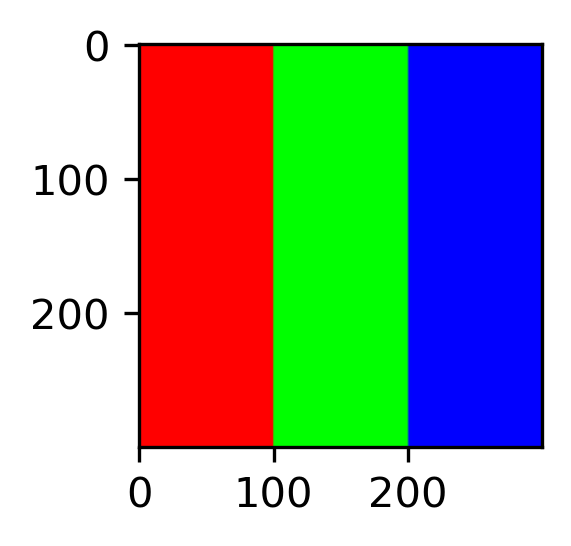

In [119]:
# Read image
rgb_calibrator = Image.open(r"png-figures/rgb-calibrator.png")
rgb_calibrator = rgb_calibrator.resize((xpix, ypix),Image.Resampling.LANCZOS)
gray_calibrator = rgb_calibrator.convert('L')

# Display image
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(rgb_calibrator)
plt.tight_layout()

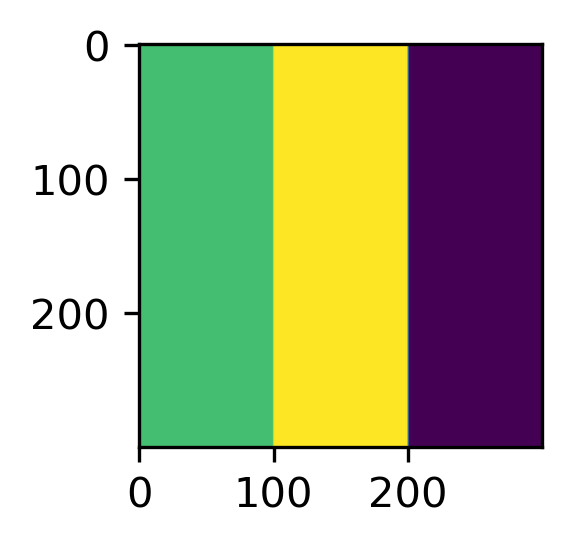

In [120]:
# Create calibrator HSI
hsi_rgb = HSI(rgb_calibrator, red_gaussian, green_lorentzian, blue_voigt, zpix, ypix, xpix, noise=2)
hsi_rgb = hsi_rgb.hyper

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(hsi_rgb[600, :, :])
plt.tight_layout()

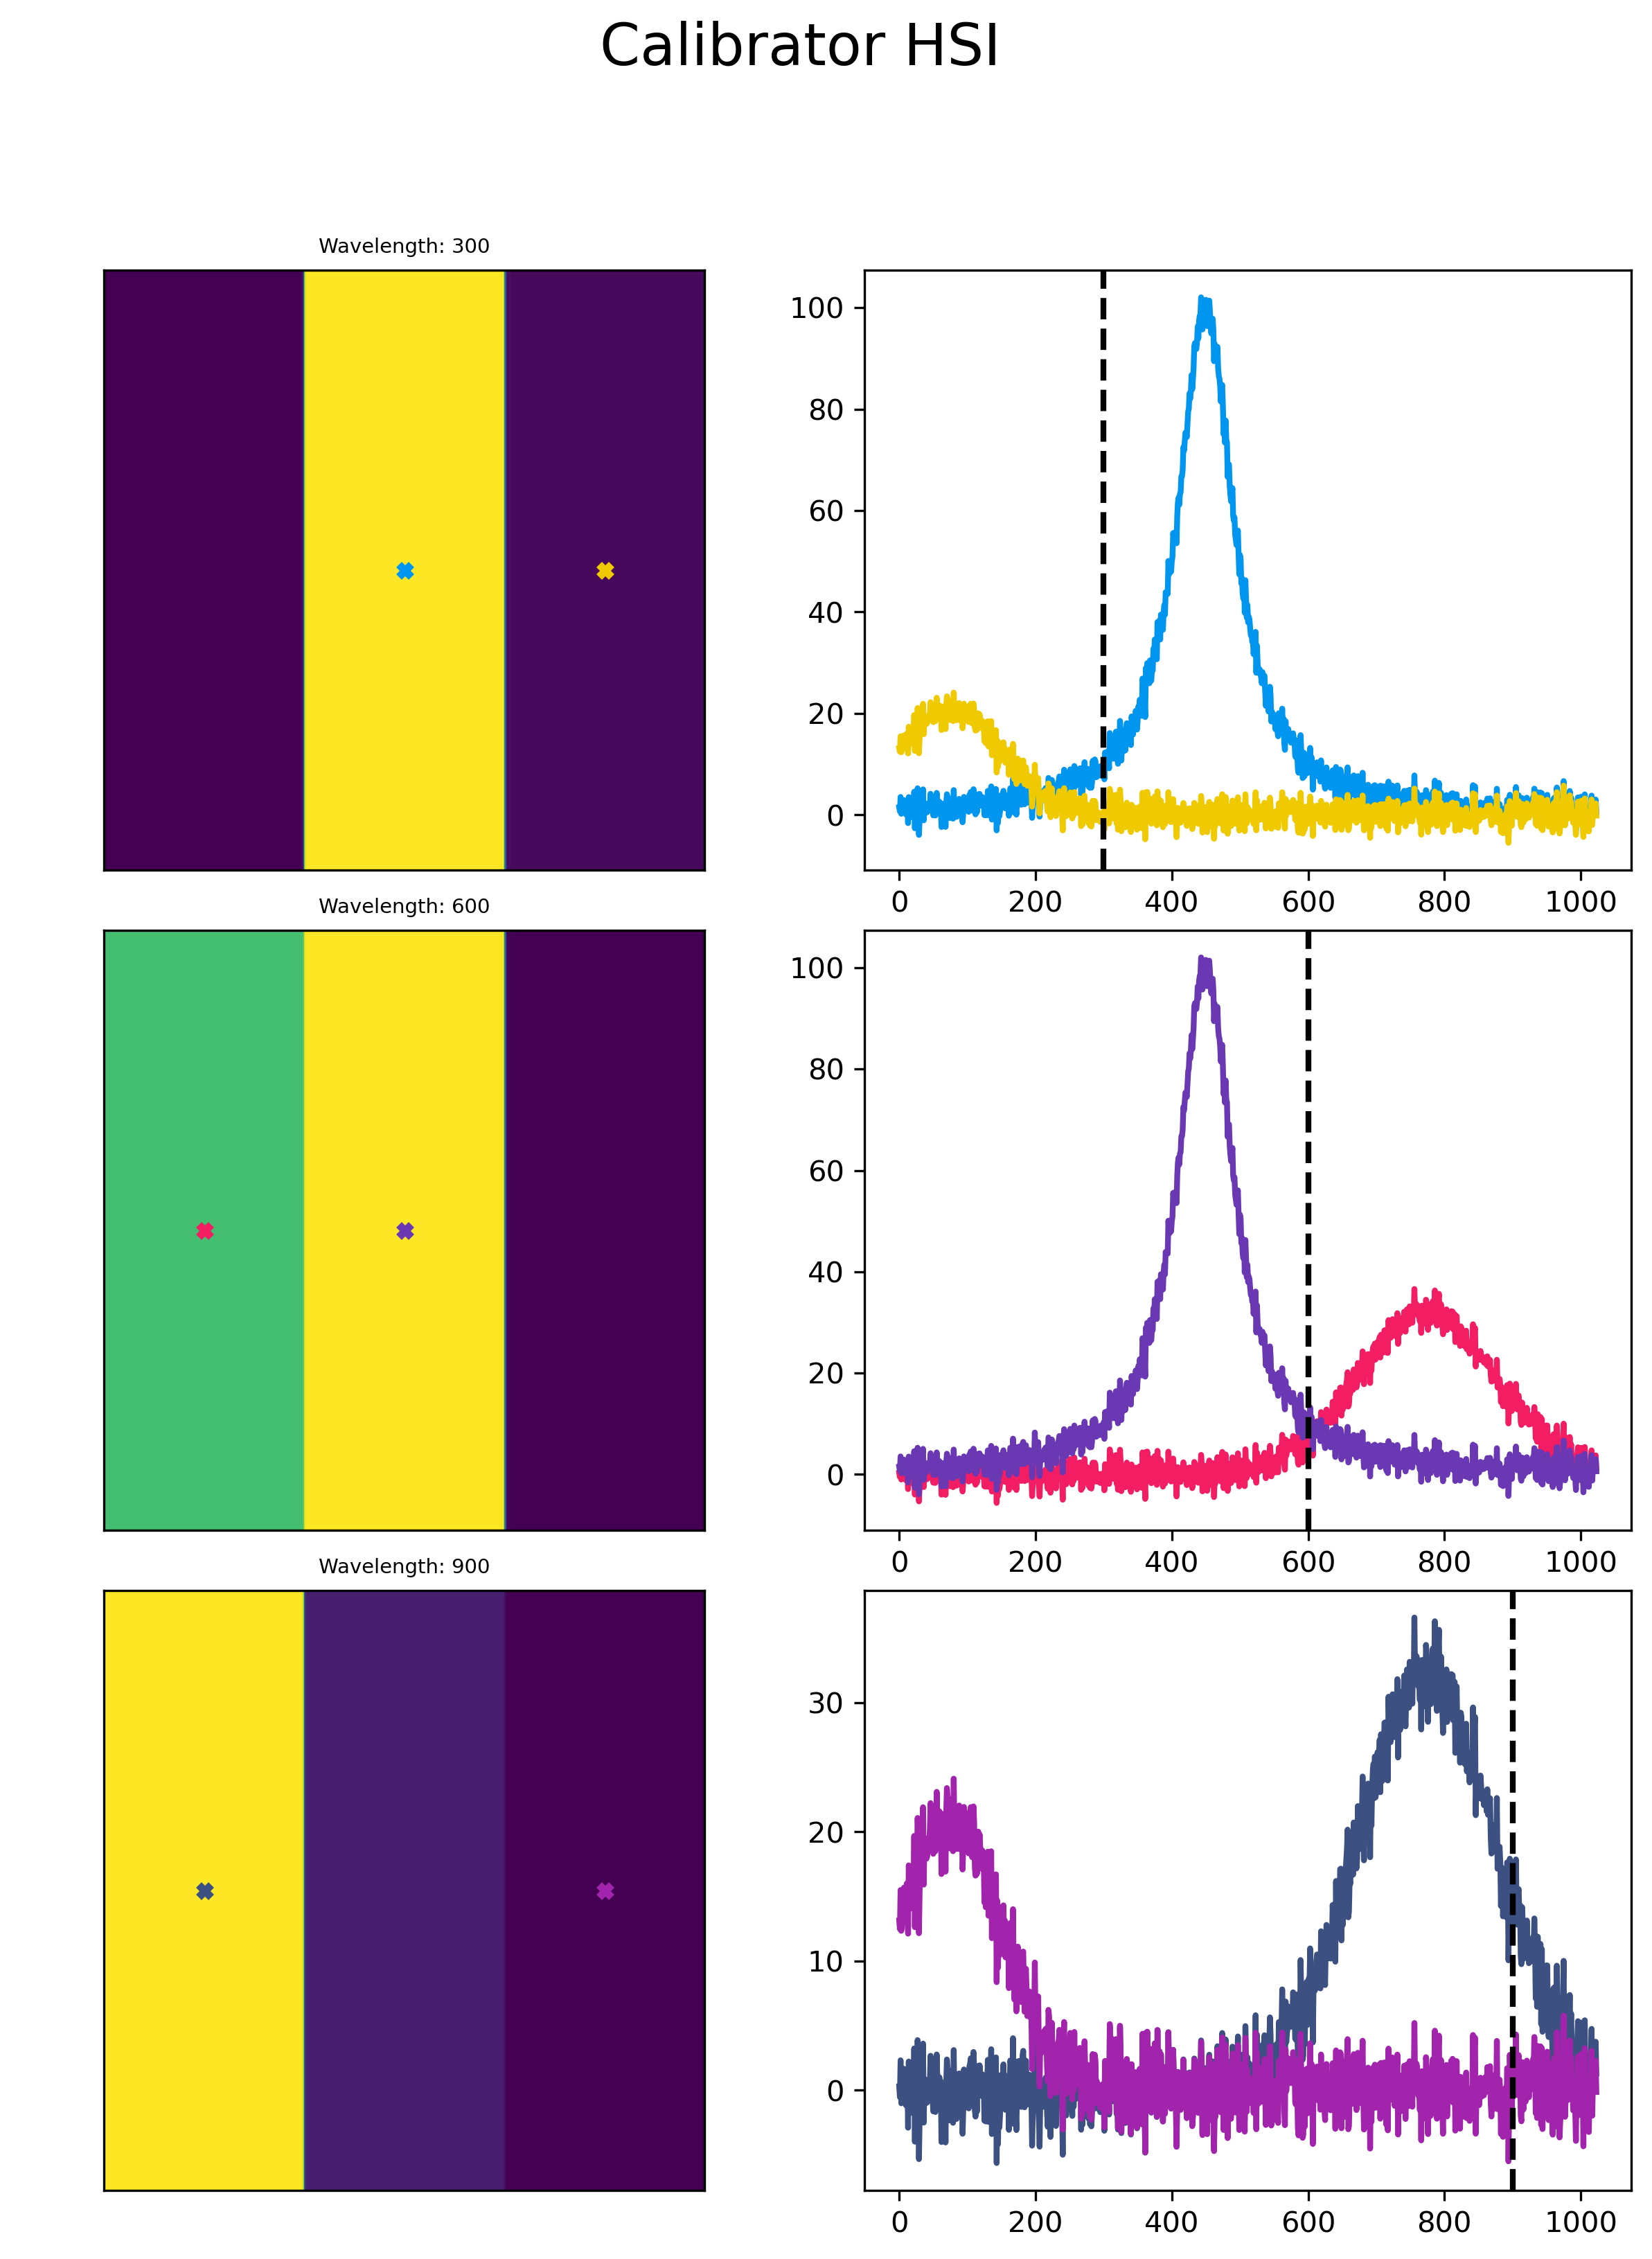

In [48]:
calibrator_pts = [[[300, 150, 150], [300, 150, 250]], [[600, 150, 50], [600, 150, 150]], 
       [[900, 150, 50], [900, 150, 250]]]

artificial_data_plot("Calibrator HSI", hsi_rgb, calibrator_pts)

# Preprocessing

## Calibrator

In [121]:
hsi_rgb_1d = np.reshape(hsi_rgb, (zpix * ypix * xpix)) # reshape to 1D

hsi_rgb_sb_mean = np.mean(hsi_rgb[920:1020, 150, 250]) 
hsi_rgb_1d = [(i - hsi_rgb_sb_mean) for i in hsi_rgb_1d]
hsi_rgb_1d = [i.clip(min=0) for i in hsi_rgb_1d]

hsi_rgb_1d = median_filter(hsi_rgb_1d, size=3, footprint=None, output=None, mode="reflect", cval=0.0, origin=0)

hsi_rgb_denoised = np.reshape(hsi_rgb_1d, (zpix, ypix, xpix))
hsi_rgb_denoised_2d = np.reshape(hsi_rgb_1d, (zpix, ypix * xpix))

print(hsi_rgb_denoised[920:1020, 150, 250])

[1.960731   0.71273075 1.94824573 0.         0.         0.8251743
 0.         1.47268678 0.         1.58221277 0.         1.42020322
 0.         0.         1.49961656 1.7450606  0.49246116 0.
 3.99760013 0.16886314 0.         1.39238101 0.52188906 1.53398898
 1.25337032 0.         0.         1.45414547 0.         0.
 0.         1.17672371 0.22372468 0.         0.18381164 0.02285804
 1.16204667 0.70306206 0.42388798 0.         0.         0.6349829
 0.         3.30838449 0.         0.53284923 0.         0.13912504
 1.40100067 0.         0.         0.         1.25371982 1.2743637
 0.         3.90887846 0.28549426 0.44114549 0.73789564 1.92231227
 1.39152333 0.47031619 0.69184677 0.         0.         0.
 1.3932465  0.31382216 2.56091325 1.00838637 0.         1.16187768
 0.         1.11090784 0.24294844 0.         0.6254849  1.82148433
 1.14024736 0.         0.         0.41940004 0.         0.
 0.67894277 1.33773145 1.23311319 0.         0.16769533 3.39557173
 3.59266654 1.77908328 0.     

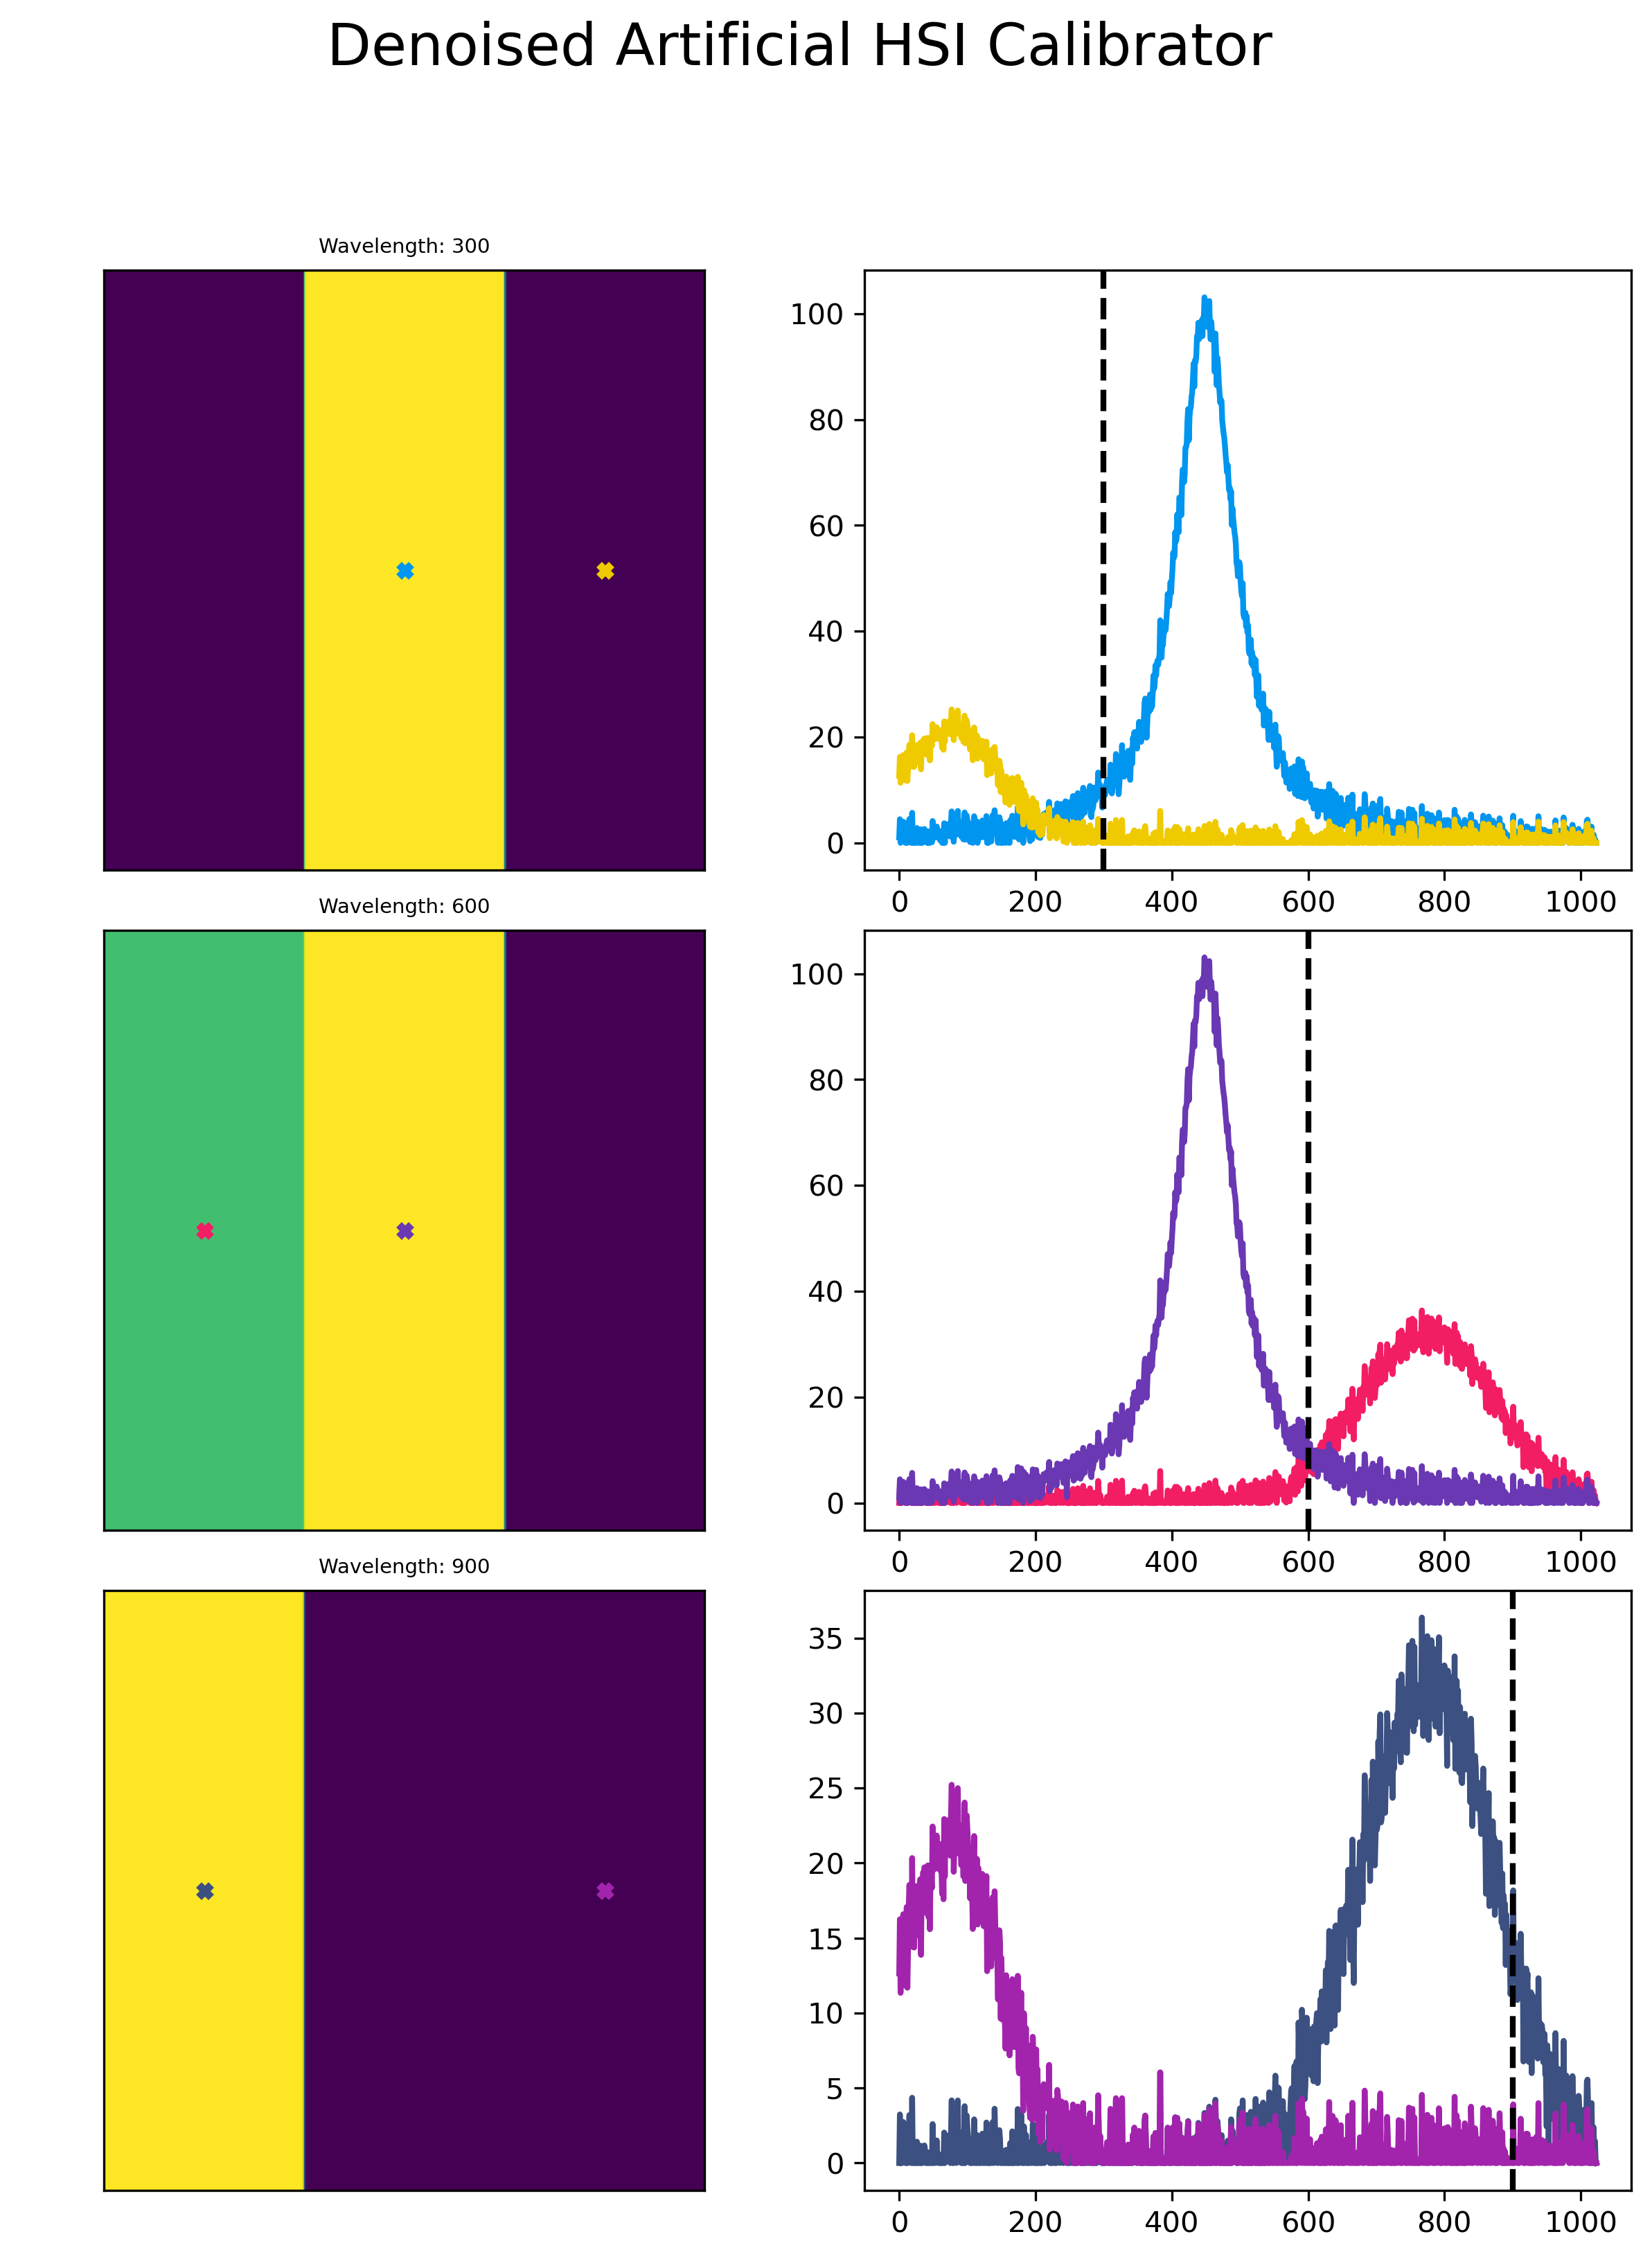

In [122]:
artificial_data_plot("Denoised Artificial HSI Calibrator", hsi_rgb_denoised, calibrator_pts)

## Noisy data

In [56]:
hsi_1d = np.reshape(hsi, (zpix * ypix * xpix)) # reshape to 1D

# subtract background
# take mean of region with values close to or equal to zero
hsi_sb_mean = np.mean(hsi[920:1020, 145, 60]) 
hsi_1d = [(i - hsi_sb_mean) for i in hsi_1d]
hsi_1d = [i.clip(min=0) for i in hsi_1d]

# add median filter
hsi_1d = median_filter(hsi_1d, size=3, footprint=None, output=None, mode="reflect", cval=0.0, origin=0)

# Set negative values equal to 0
#for i in range(len(hsi_1d)):
#    if hsi_1d[i] < 0:
#        hsi_1d[i] = 0
hsi_denoised = np.reshape(hsi_1d, (zpix, ypix, xpix))
hsi_denoised_2d = np.reshape(hsi_1d, (zpix, ypix * xpix))

print(hsi_denoised[920:1020, 145, 60])

[1.04520958 0.82921062 0.34688334 0.65602633 0.         0.
 0.         0.79243486 0.28586468 1.07545234 0.46250579 0.9161897
 0.         1.41172348 0.21142464 0.54721092 0.         0.64825311
 0.         1.4786547  0.         0.0046044  0.         0.
 0.         1.50746838 0.16057691 0.68897962 0.5165267  1.96317809
 0.41173046 1.06874348 0.         1.13844452 0.4987277  0.
 1.98619962 0.         2.16007445 0.         0.         0.
 2.21549873 0.55135646 0.         0.91194225 0.         1.75175823
 0.         0.45055226 0.         0.         0.34882719 1.62497506
 0.         1.84547893 1.36743186 0.         0.         0.
 3.0327485  0.         0.45197925 0.         0.8562794  0.
 0.40647644 0.47983673 0.36607922 0.65532017 2.30099349 0.
 1.64197389 1.38123372 0.         0.         0.         0.50485584
 0.86756909 1.60903416 0.68508125 3.46869642 0.         2.94934071
 0.         0.         0.72660837 0.         0.         0.
 0.         2.01103108 0.         0.         0.3674219  0.
 

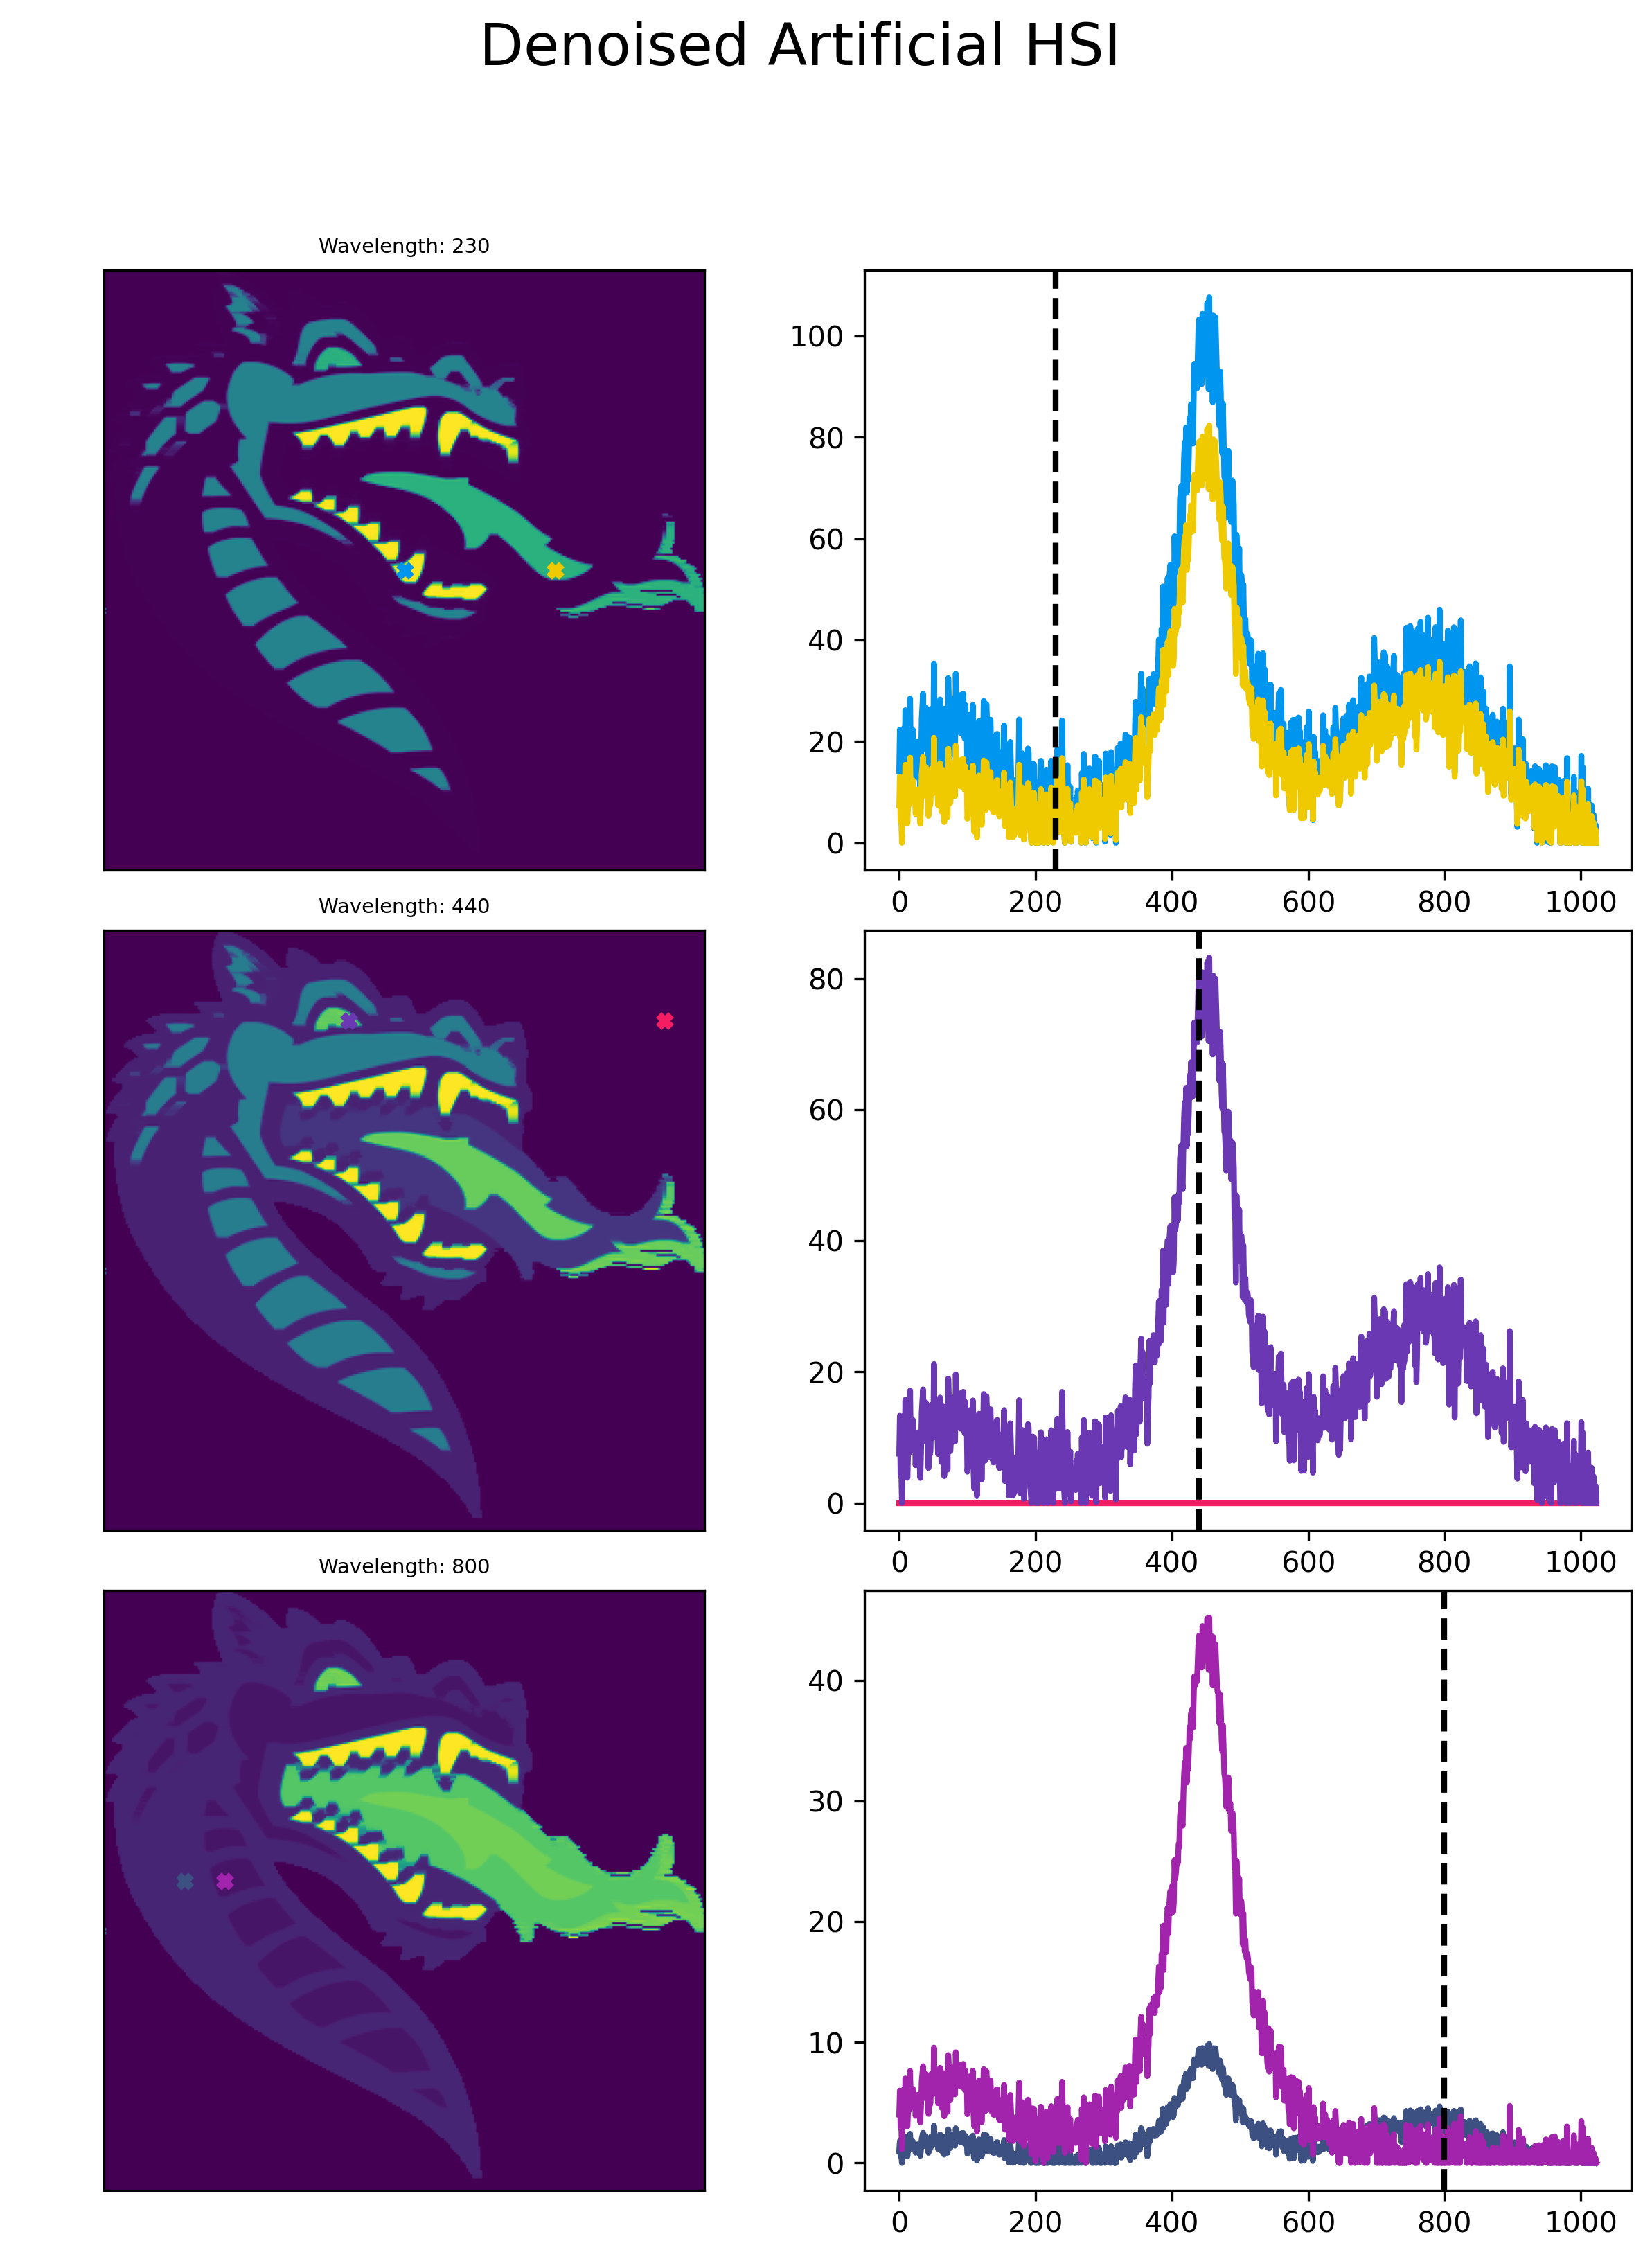

In [58]:
artificial_data_plot("Denoised Artificial HSI", hsi_denoised, pts)

# NMF on Artificial Data

## NMF Plots

In [69]:
def nmf_plot(suptitle, spect_matrices, img_matrices, xpix, ypix, save=False):

    rows = len(spect_matrices)
    columns = len(img_matrices)+3
    gs = GridSpec(rows, columns)
    gs.update(wspace=0.09,hspace=0)
    figaspect = plt.figaspect(float(ypix*3)/float(xpix*6))
    figsize = (5,8/(figaspect[0]/figaspect[1]))

    fig = plt.figure(figsize=figsize)
    #fig.patch.set_facecolor('#00000000')
    fig.suptitle(suptitle, fontsize=10)

    row_count = 0
    for i in range(rows):

        fig_plt = fig.add_subplot(gs[row_count,:2])
        fig_plt.set_xlim([0, 299])

        column_count = 0
        for j in range(row_count + 2):

            fig_img = fig.add_subplot(gs[row_count, column_count + 2])
            fig_img.imshow(img_matrices[row_count][column_count, :].reshape(ypix, xpix))
            fig_img.set_xticks([])
            fig_img.set_yticks([])
            fig_img.tick_params(color=color[j])
            for spine in fig_img.spines.values():
                spine.set_edgecolor(color[j])
                spine.set(lw=2)

            fig_plt.plot(spect_matrices[row_count][:, column_count], c=color[j], lw=1)
            fig_plt.set_xticks([])
            fig_plt.set_xticklabels([])
            fig_plt.tick_params(axis='both', direction='out', length=3, width=1, labelsize=3)
            if row_count == rows-1:
                fig_plt.set_xticks([75, 150, 225])
                fig_plt.set_xticklabels([75, 150, 225])

            column_count += 1

        row_count += 1
    
    if save:
        fig.savefig(save_directory + suptitle + file_extension)
    plt.show()

## Blind NMF with Nimfa

### Calibrator

In [129]:
iterations = 200
update = "euclidean"
objective = "fro" # frobenius norm objective function
test_conv = 10 # how often convergence test is done
min_residuals = None # minimum required improvement of residuals from previous iteration

nmf0_2comp = nimfa.Nmf(hsi_rgb_denoised_2d, max_iter=iterations, rank=2, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf0_2comp_fit = nmf0_2comp()
nmf0_2comp_W = nmf0_2comp_fit.basis()
nmf0_2comp_H = nmf0_2comp_fit.coef()

nmf0_3comp = nimfa.Nmf(hsi_rgb_denoised_2d, max_iter=iterations, rank=3, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf0_3comp_fit = nmf0_3comp()
nmf0_3comp_W = nmf0_3comp_fit.basis()
nmf0_3comp_H = nmf0_3comp_fit.coef()

nmf0_4comp = nimfa.Nmf(hsi_rgb_denoised_2d, max_iter=iterations, rank=4, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf0_4comp_fit = nmf0_4comp()
nmf0_4comp_W = nmf0_4comp_fit.basis()
nmf0_4comp_H = nmf0_4comp_fit.coef()

nmf0_5comp = nimfa.Nmf(hsi_rgb_denoised_2d, max_iter=iterations, rank=5, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf0_5comp_fit = nmf0_5comp()
nmf0_5comp_W = nmf0_5comp_fit.basis()
nmf0_5comp_H = nmf0_5comp_fit.coef()

nmf0_6comp = nimfa.Nmf(hsi_rgb_denoised_2d, max_iter=iterations, rank=6, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf0_6comp_fit = nmf0_6comp()
nmf0_6comp_W = nmf0_6comp_fit.basis()
nmf0_6comp_H = nmf0_6comp_fit.coef()

# Arrays of matrices
nmf0_spect_matrices = [nmf0_2comp_W, nmf0_3comp_W, nmf0_4comp_W, nmf0_5comp_W, nmf0_6comp_W]
nmf0_img_matrices = [nmf0_2comp_H, nmf0_3comp_H, nmf0_4comp_H, nmf0_5comp_H, nmf0_6comp_H]

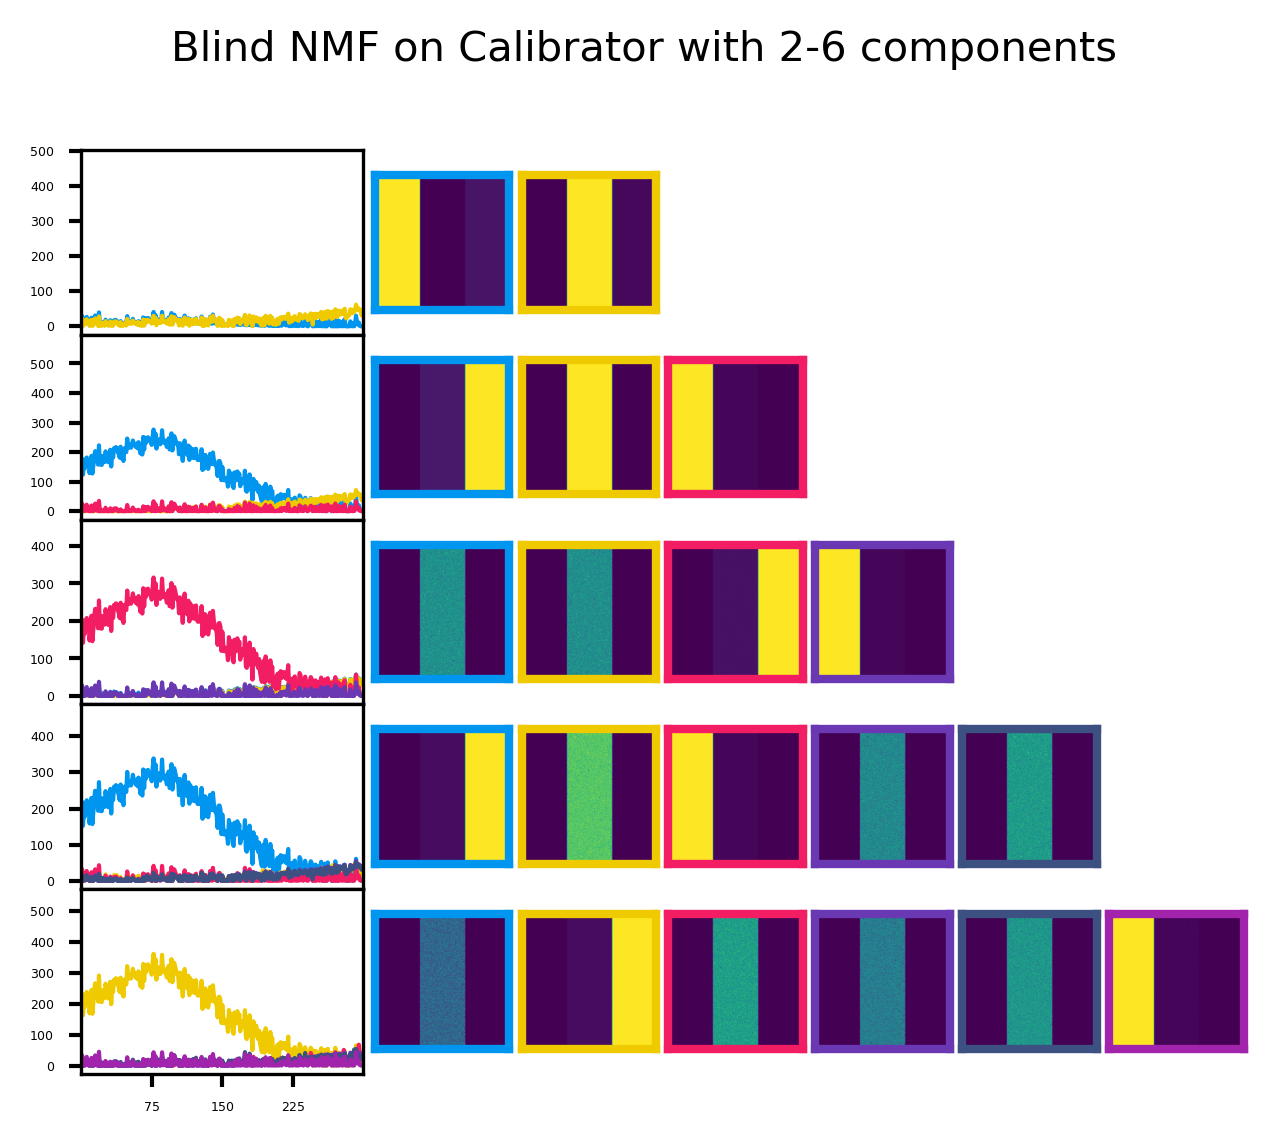

In [130]:
nmf_plot("Blind NMF on Calibrator 2-6 components", nmf0_spect_matrices, 
         nmf0_img_matrices, xpix, ypix)

### Noiseless artificial data

In [113]:
hsi1_2d = np.reshape(hsi1, (zpix, ypix * xpix))

iterations = 200
update = "euclidean"
objective = "fro" # frobenius norm objective function
test_conv = 10 # how often convergence test is done
min_residuals = None # minimum required improvement of residuals from previous iteration

nmf1_2comp = nimfa.Nmf(hsi1_2d, max_iter=iterations, rank=2, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf1_2comp_fit = nmf1_2comp()
nmf1_2comp_W = nmf1_2comp_fit.basis()
nmf1_2comp_H = nmf1_2comp_fit.coef()

nmf1_3comp = nimfa.Nmf(hsi1_2d, max_iter=iterations, rank=3, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf1_3comp_fit = nmf1_3comp()
nmf1_3comp_W = nmf1_3comp_fit.basis()
nmf1_3comp_H = nmf1_3comp_fit.coef()

nmf1_4comp = nimfa.Nmf(hsi1_2d, max_iter=iterations, rank=4, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf1_4comp_fit = nmf1_4comp()
nmf1_4comp_W = nmf1_4comp_fit.basis()
nmf1_4comp_H = nmf1_4comp_fit.coef()

nmf1_5comp = nimfa.Nmf(hsi1_2d, max_iter=iterations, rank=5, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf1_5comp_fit = nmf1_5comp()
nmf1_5comp_W = nmf1_5comp_fit.basis()
nmf1_5comp_H = nmf1_5comp_fit.coef()

nmf1_6comp = nimfa.Nmf(hsi1_2d, max_iter=iterations, rank=6, update=update, objective=objective, 
                       test_conv=test_conv, min_residuals=min_residuals)
nmf1_6comp_fit = nmf1_6comp()
nmf1_6comp_W = nmf1_6comp_fit.basis()
nmf1_6comp_H = nmf1_6comp_fit.coef()

# Arrays of matrices
nmf1_spect_matrices = [nmf1_2comp_W, nmf1_3comp_W, nmf1_4comp_W, nmf1_5comp_W, nmf1_6comp_W]
nmf1_img_matrices = [nmf1_2comp_H, nmf1_3comp_H, nmf1_4comp_H, nmf1_5comp_H, nmf1_6comp_H]

#nmf1_spect_matrices = [nmf1_2comp_W]
#nmf1_img_matrices = [nmf1_2comp_H]

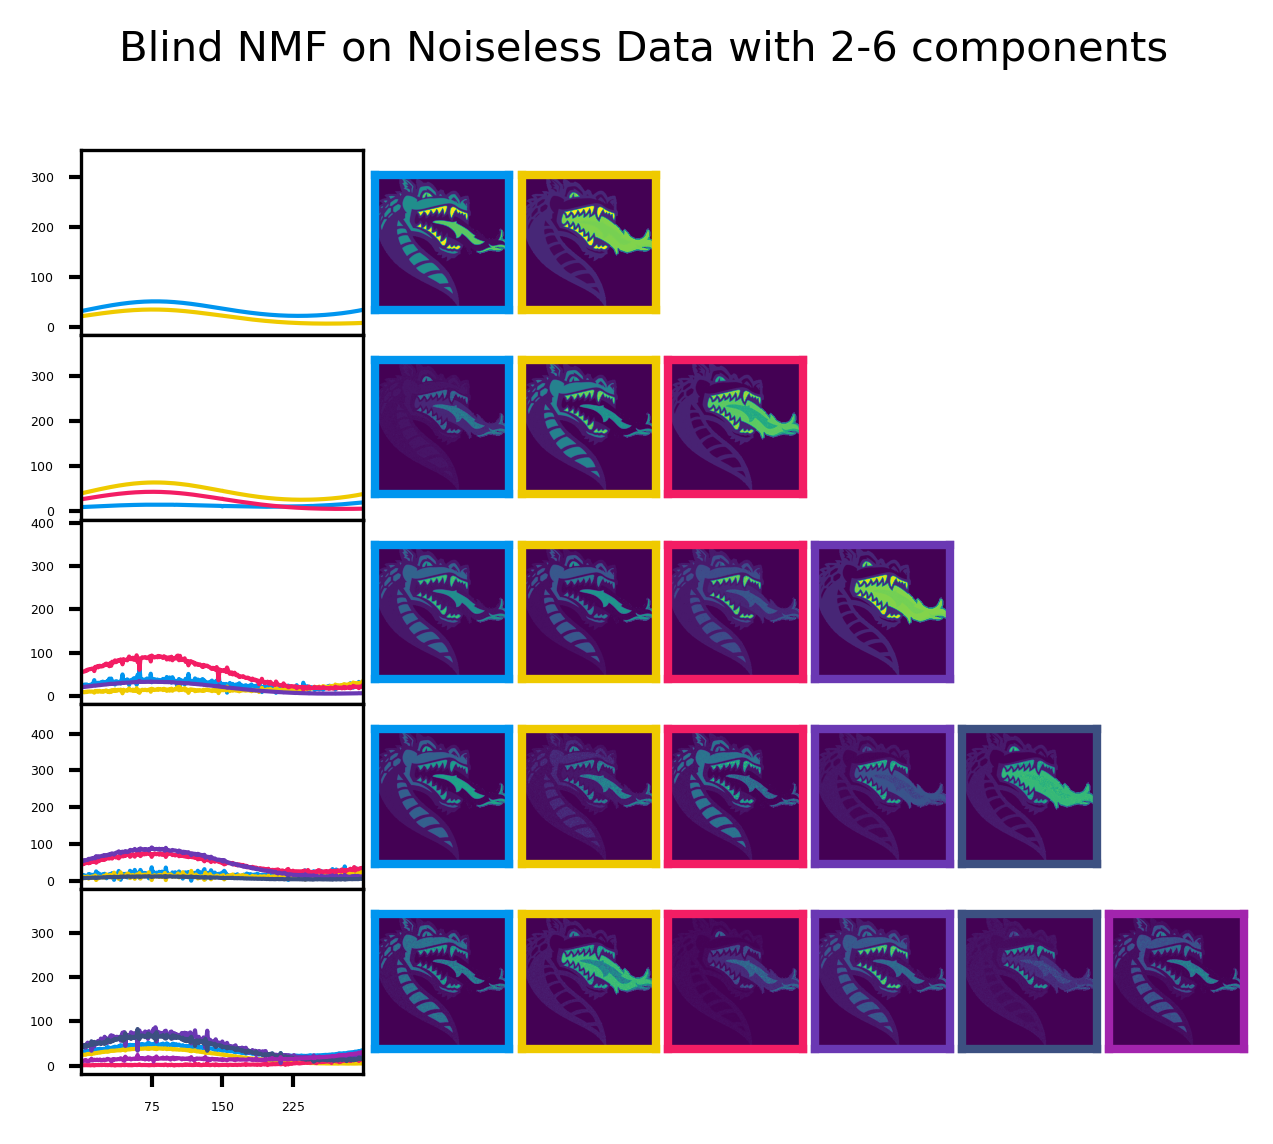

In [114]:
nmf_plot("Blind NMF on Noiseless Artificial Data 2-6 components", nmf1_spect_matrices, 
         nmf1_img_matrices, xpix, ypix)

### Noisy artificial data

In [141]:
iterations = 200
update = "euclidean"
objective = "fro" # frobenius norm objective function
test_conv = 20
min_residuals = None

nmf2_2comp = nimfa.Nmf(hsi_denoised_2d, max_iter=iterations, rank=2, update=update, 
                      objective=objective, test_conv=test_conv, min_residuals=min_residuals)
nmf2_2comp_fit = nmf2_2comp()
nmf2_2comp_W = nmf2_2comp_fit.basis()
nmf2_2comp_H = nmf2_2comp_fit.coef()

nmf2_3comp = nimfa.Nmf(hsi_denoised_2d, max_iter=iterations, rank=3, update=update, 
                      objective=objective, test_conv=test_conv, min_residuals=min_residuals)
nmf2_3comp_fit = nmf2_3comp()
nmf2_3comp_W = nmf2_3comp_fit.basis()
nmf2_3comp_H = nmf2_3comp_fit.coef()

nmf2_4comp = nimfa.Nmf(hsi_denoised_2d, max_iter=iterations, rank=4, update=update, 
                      objective=objective, test_conv=test_conv, min_residuals=min_residuals)
nmf2_4comp_fit = nmf2_4comp()
nmf2_4comp_W = nmf2_4comp_fit.basis()
nmf2_4comp_H = nmf2_4comp_fit.coef()

nmf2_5comp = nimfa.Nmf(hsi_denoised_2d, max_iter=iterations, rank=5, update=update, 
                      objective=objective, test_conv=test_conv, min_residuals=min_residuals)
nmf2_5comp_fit = nmf2_5comp()
nmf2_5comp_W = nmf2_5comp_fit.basis()
nmf2_5comp_H = nmf2_5comp_fit.coef()

nmf2_6comp = nimfa.Nmf(hsi_denoised_2d, max_iter=iterations, rank=6, update=update, 
                      objective=objective, test_conv=test_conv, min_residuals=min_residuals)
nmf2_6comp_fit = nmf2_6comp()
nmf2_6comp_W = nmf2_6comp_fit.basis()
nmf2_6comp_H = nmf2_6comp_fit.coef()

# Arrays of matrices
nmf2_spect_matrices = [nmf2_2comp_W, nmf2_3comp_W, nmf2_4comp_W, nmf2_5comp_W, nmf2_6comp_W]
nmf2_img_matrices = [nmf2_2comp_H, nmf2_3comp_H, nmf2_4comp_H, nmf2_5comp_H, nmf2_6comp_H]

In [ ]:
nmf_plot("Blind NMF on Noisy Artificial Data 2-6 Components", 
         nmf2_spect_matrices, nmf2_img_matrices, xpix, ypix)

In [148]:
nmf_plot("Blind NMF on Noisy Artificial Data 2-6 Components", 
         nmf_spect_matrices, nmf_img_matrices, xpix, ypix)

## Blind NMF with Scikit-learn

In [134]:
init = "random"
solver = "cd"
beta_loss = "frobenius"
tolerance = 0
iterations = 200
random_state = None
alpha_W = 0.0
alpha_H = "same"
l1_ratio = 0.0
verbose = 0
shuffle = False


# 2 Components
nmf_2comp = NMF(n_components=2, init=init, solver=solver, beta_loss=beta_loss, 
                tol=tolerance, max_iter=iterations, random_state=random_state, alpha_W=alpha_W, 
                   alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
# 3 Components
nmf_3comp = NMF(n_components=3, init=init, solver=solver, beta_loss=beta_loss, 
                tol=tolerance, max_iter=iterations, random_state=random_state, alpha_W=alpha_W, 
                   alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
# 4 Components
nmf_4comp = NMF(n_components=4, init=init, solver=solver, beta_loss=beta_loss, 
                tol=tolerance, max_iter=iterations, random_state=random_state, alpha_W=alpha_W, 
                   alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
# 5 Components
nmf_5comp = NMF(n_components=5, init=init, solver=solver, beta_loss=beta_loss, 
                tol=tolerance, max_iter=iterations, random_state=random_state, alpha_W=alpha_W, 
                   alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
# 6 Components
nmf_6comp = NMF(n_components=6, init=init, solver=solver, beta_loss=beta_loss, 
                tol=tolerance, max_iter=iterations, random_state=random_state, alpha_W=alpha_W, 
                   alpha_H=alpha_H, l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)

### Calibrator

In [137]:
# 2 Components
rgb_nmf_2comp = nmf_2comp
W_rgb_nmf_2comp = rgb_nmf_2comp.fit_transform(hsi_rgb_denoised_2d)
H_rgb_nmf_2comp = rgb_nmf_2comp.components_
# 3 Components
rgb_nmf_3comp = nmf_3comp
W_rgb_nmf_3comp = rgb_nmf_3comp.fit_transform(hsi_rgb_denoised_2d)
H_rgb_nmf_3comp = rgb_nmf_3comp.components_
# 4 Components
rgb_nmf_4comp = nmf_4comp
W_rgb_nmf_4comp = rgb_nmf_4comp.fit_transform(hsi_rgb_denoised_2d)
H_rgb_nmf_4comp = rgb_nmf_4comp.components_
# 5 Components
rgb_nmf_5comp = nmf_5comp
W_rgb_nmf_5comp = rgb_nmf_5comp.fit_transform(hsi_rgb_denoised_2d)
H_rgb_nmf_5comp = rgb_nmf_5comp.components_
# 6 Components
rgb_nmf_6comp = nmf_6comp
W_rgb_nmf_6comp = rgb_nmf_6comp.fit_transform(hsi_rgb_denoised_2d)
H_rgb_nmf_6comp = rgb_nmf_6comp.components_

# Spectral components
rgb_nmf_spect_matrices = [W_rgb_nmf_2comp, W_rgb_nmf_3comp, W_rgb_nmf_4comp, W_rgb_nmf_5comp, 
                         W_rgb_nmf_6comp]
# Image components
rgb_nmf_img_matrices = [H_rgb_nmf_2comp, H_rgb_nmf_3comp, H_rgb_nmf_4comp, H_rgb_nmf_5comp, 
                       H_rgb_nmf_6comp]

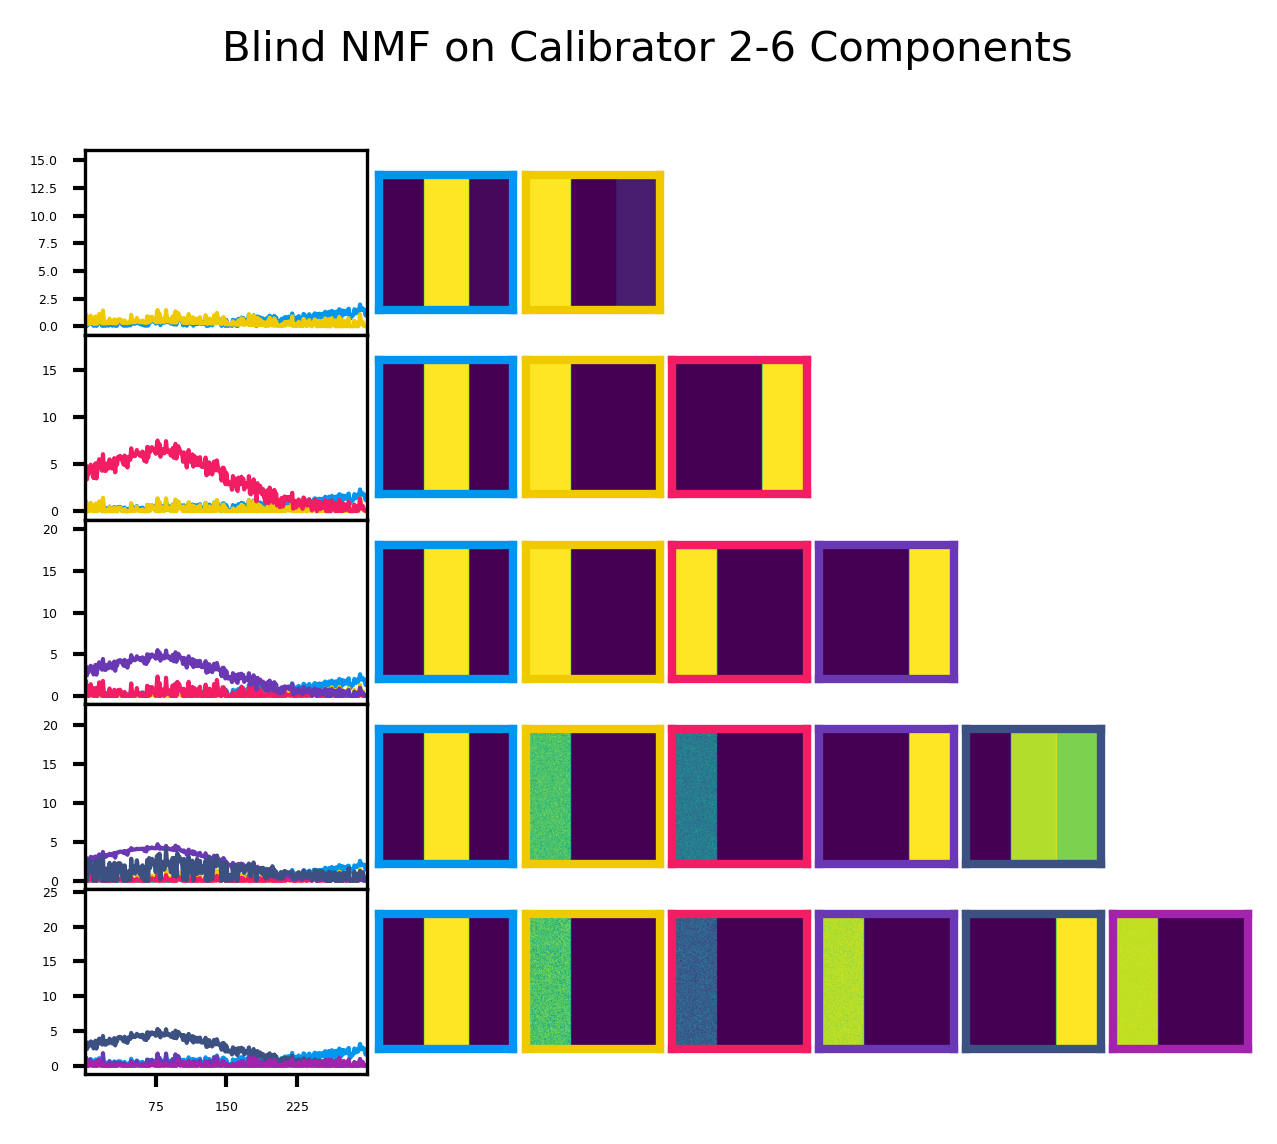

In [138]:
nmf_plot("Blind NMF on Calibrator 2-6 Components", 
         rgb_nmf_spect_matrices, rgb_nmf_img_matrices, xpix, ypix)

### Noiseless artificial data

In [139]:
# 2 Components
hsi1_nmf_2comp = nmf_2comp
W_hsi1_nmf_2comp = hsi1_nmf_2comp.fit_transform(hsi1_2d)
H_hsi1_nmf_2comp = hsi1_nmf_2comp.components_
# 3 Components
hsi1_nmf_3comp = nmf_3comp
W_hsi1_nmf_3comp = hsi1_nmf_3comp.fit_transform(hsi1_2d)
H_hsi1_nmf_3comp = hsi1_nmf_3comp.components_
# 4 Components
hsi1_nmf_4comp = nmf_4comp
W_hsi1_nmf_4comp = hsi1_nmf_4comp.fit_transform(hsi1_2d)
H_hsi1_nmf_4comp = hsi1_nmf_4comp.components_
# 5 Components
hsi1_nmf_5comp = nmf_5comp
W_hsi1_nmf_5comp = hsi1_nmf_5comp.fit_transform(hsi1_2d)
H_hsi1_nmf_5comp = hsi1_nmf_5comp.components_
# 6 Components
hsi1_nmf_6comp = nmf_6comp
W_hsi1_nmf_6comp = hsi1_nmf_6comp.fit_transform(hsi1_2d)
H_hsi1_nmf_6comp = hsi1_nmf_6comp.components_

# Spectral components
hsi1_nmf_spect_matrices = [W_hsi1_nmf_2comp, W_hsi1_nmf_3comp, W_hsi1_nmf_4comp, W_hsi1_nmf_5comp, 
                         W_hsi1_nmf_6comp]
# Image components
hsi1_nmf_img_matrices = [H_hsi1_nmf_2comp, H_hsi1_nmf_3comp, H_hsi1_nmf_4comp, H_hsi1_nmf_5comp, 
                       H_hsi1_nmf_6comp]

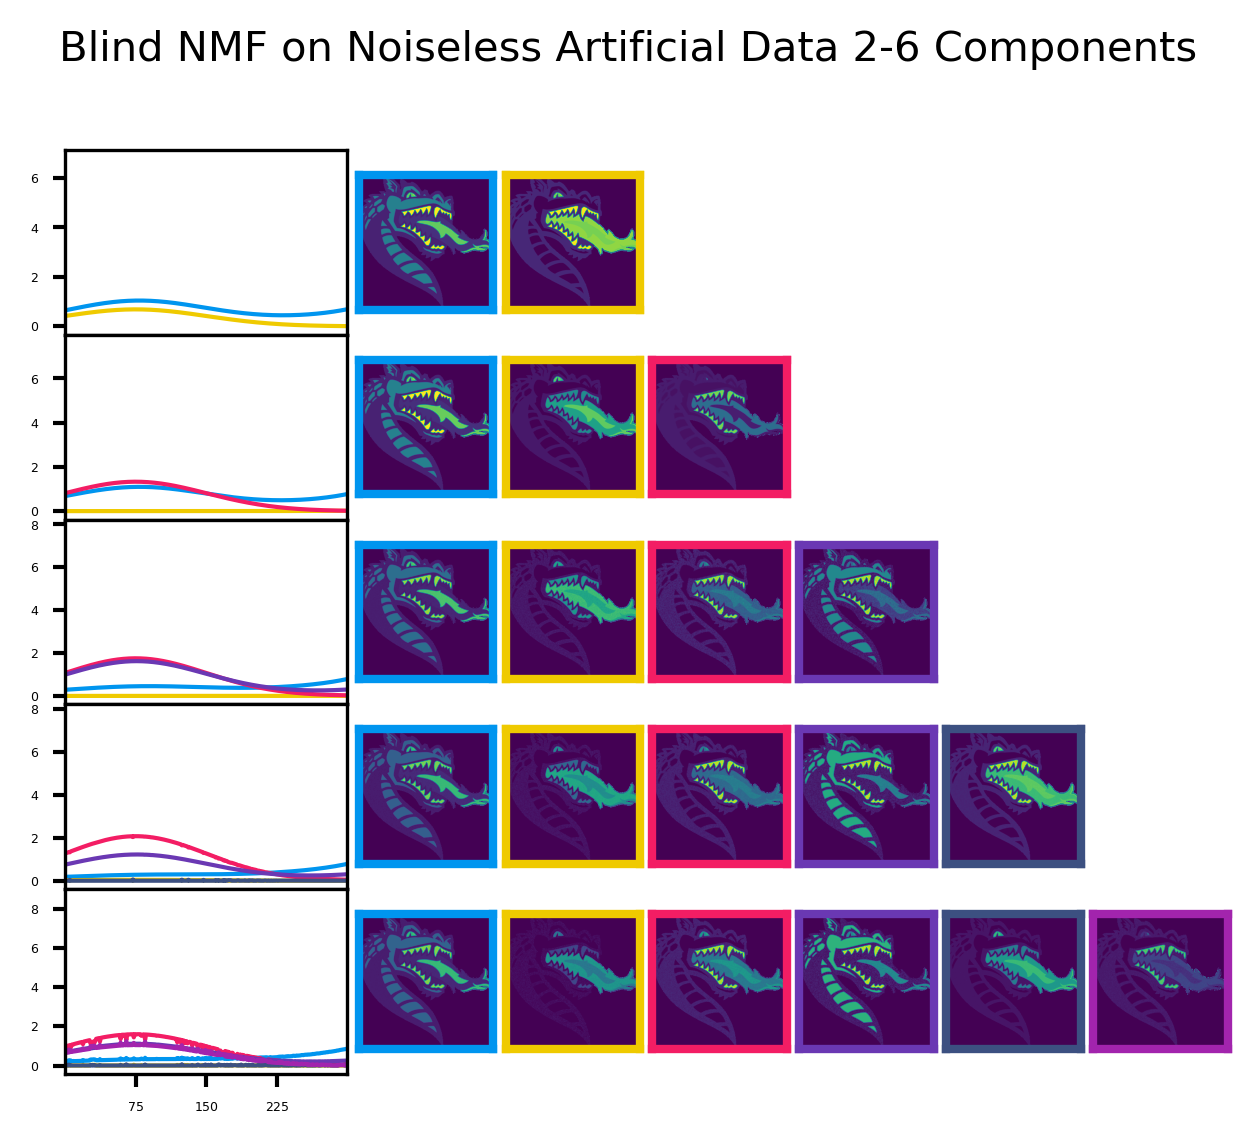

In [140]:
nmf_plot("Blind NMF on Noiseless Artificial Data 2-6 Components", 
         hsi1_nmf_spect_matrices, hsi1_nmf_img_matrices, xpix, ypix)

### Noisy artificial data

In [135]:
# 2 Components
hsi_nmf_2comp = nmf_2comp
W_hsi_nmf_2comp = hsi_nmf_2comp.fit_transform(hsi_denoised_2d)
H_hsi_nmf_2comp = hsi_nmf_2comp.components_
# 3 Components
hsi_nmf_3comp = nmf_3comp
W_hsi_nmf_3comp = hsi_nmf_3comp.fit_transform(hsi_denoised_2d)
H_hsi_nmf_3comp = hsi_nmf_3comp.components_
# 4 Components
hsi_nmf_4comp = nmf_4comp
W_hsi_nmf_4comp = hsi_nmf_4comp.fit_transform(hsi_denoised_2d)
H_hsi_nmf_4comp = hsi_nmf_4comp.components_
# 5 Components
hsi_nmf_5comp = nmf_5comp
W_hsi_nmf_5comp = hsi_nmf_5comp.fit_transform(hsi_denoised_2d)
H_hsi_nmf_5comp = hsi_nmf_5comp.components_
# 6 Components
hsi_nmf_6comp = nmf_6comp
W_hsi_nmf_6comp = hsi_nmf_6comp.fit_transform(hsi_denoised_2d)
H_hsi_nmf_6comp = hsi_nmf_6comp.components_

# Spectral components
hsi_nmf_spect_matrices = [W_hsi_nmf_2comp, W_hsi_nmf_3comp, W_hsi_nmf_4comp, W_hsi_nmf_5comp, 
                         W_hsi_nmf_6comp]
# Image components
hsi_nmf_img_matrices = [H_hsi_nmf_2comp, H_hsi_nmf_3comp, H_hsi_nmf_4comp, H_hsi_nmf_5comp, 
                       H_hsi_nmf_6comp]

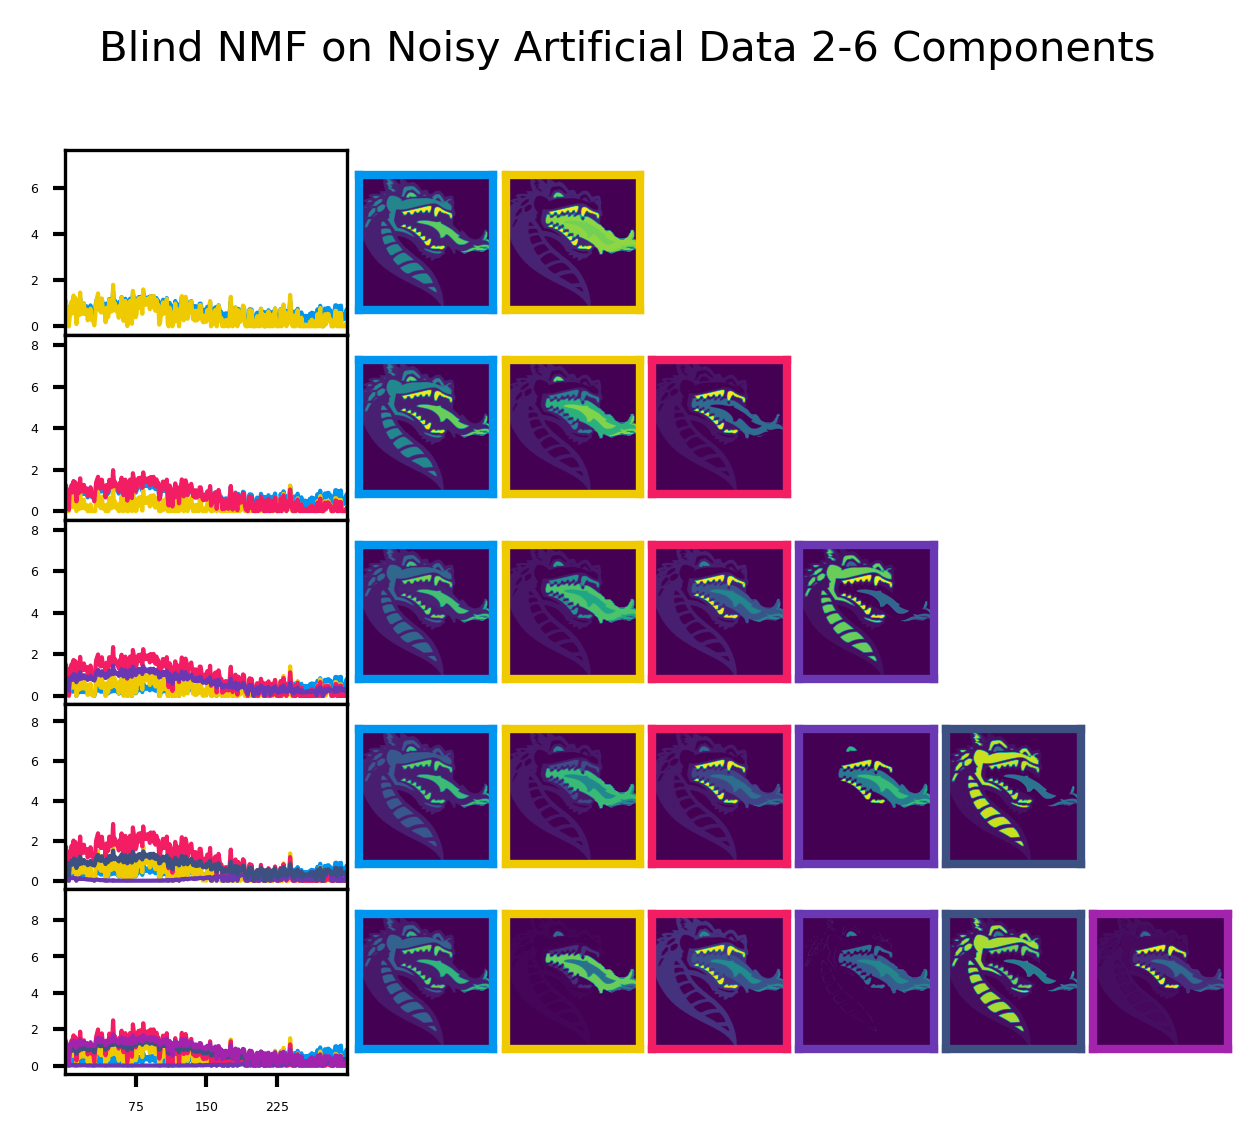

In [136]:
nmf_plot("Blind NMF on Noisy Artificial Data 2-6 Components", 
         hsi_nmf_spect_matrices, hsi_nmf_img_matrices, xpix, ypix)

## Explained Variance

In [175]:
#def error_analysis(models):
#    temp = []
#    for model in models:
#        temp.append(model.evar())
#    return temp

def get_variance(model, data):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data))
    return metrics.explained_variance_score(data, prediction, multioutput="variance_weighted")

def error_analysis(models, data):
    temp = []
    for model in models:
        temp.append(get_variance(model.fit(data), data))
    return temp

def explained_variance_plot(suptitle, rgb_results, hsi1_results, hsi_results, save=False):

    fig = plt.figure(figsize=(4, 3))
    #fig.patch.set_facecolor("#00000000")
    gs = GridSpec(1, 1)
    gs.update(wspace=0.1, hspace=0.1)
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    fig_plt = fig.add_subplot(gs[0, 0])
    fig_plt.plot([2, 3, 4, 5, 6], rgb_results[0], ms=10, marker='o', lw=2, c=color[0], label="Calibrator")
    fig_plt.plot([2, 3, 4, 5, 6], hsi1_results[0], ms=10, marker='o', lw=2, c=color[1], label="Noiseless Data")
    fig_plt.plot([2, 3, 4, 5, 6], hsi_results[0], ms=10, marker='o', lw=2, c=color[2], label="Noisy Data")

    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    fig_plt.set_title(suptitle)
    fig_plt.set_ylabel("EVR")
    fig_plt.set_xlabel("Number of Components")
    fig_plt.set_ylim(0.98, 1.001)
    fig_plt.set_xticks([2, 3, 4, 5, 6])
    fig_plt.set_xticklabels([2, 3, 4, 5, 6])
    fig_plt.tick_params(axis='both', direction='out', length=6, width=2, labelsize=6)
    fig_plt.grid()
    fig_plt.legend()

    if save:
        fig.savefig(save_directory + suptitle + file_extension)

In [166]:
rgb_nmf_models = [rgb_nmf_2comp, rgb_nmf_3comp, rgb_nmf_4comp, rgb_nmf_5comp, rgb_nmf_6comp]
rgb_nmf_results = [error_analysis(rgb_nmf_models, hsi_rgb_denoised_2d)]

hsi1_nmf_models = [hsi1_nmf_2comp, hsi1_nmf_3comp, hsi1_nmf_4comp, hsi1_nmf_5comp, hsi1_nmf_6comp]
hsi1_nmf_results = [error_analysis(hsi1_nmf_models, hsi1_2d)]

hsi_nmf_models = [hsi_nmf_2comp, hsi_nmf_3comp, hsi_nmf_4comp, hsi_nmf_5comp, hsi_nmf_6comp]
hsi_nmf_results = [error_analysis(hsi_nmf_models, hsi_denoised_2d)]

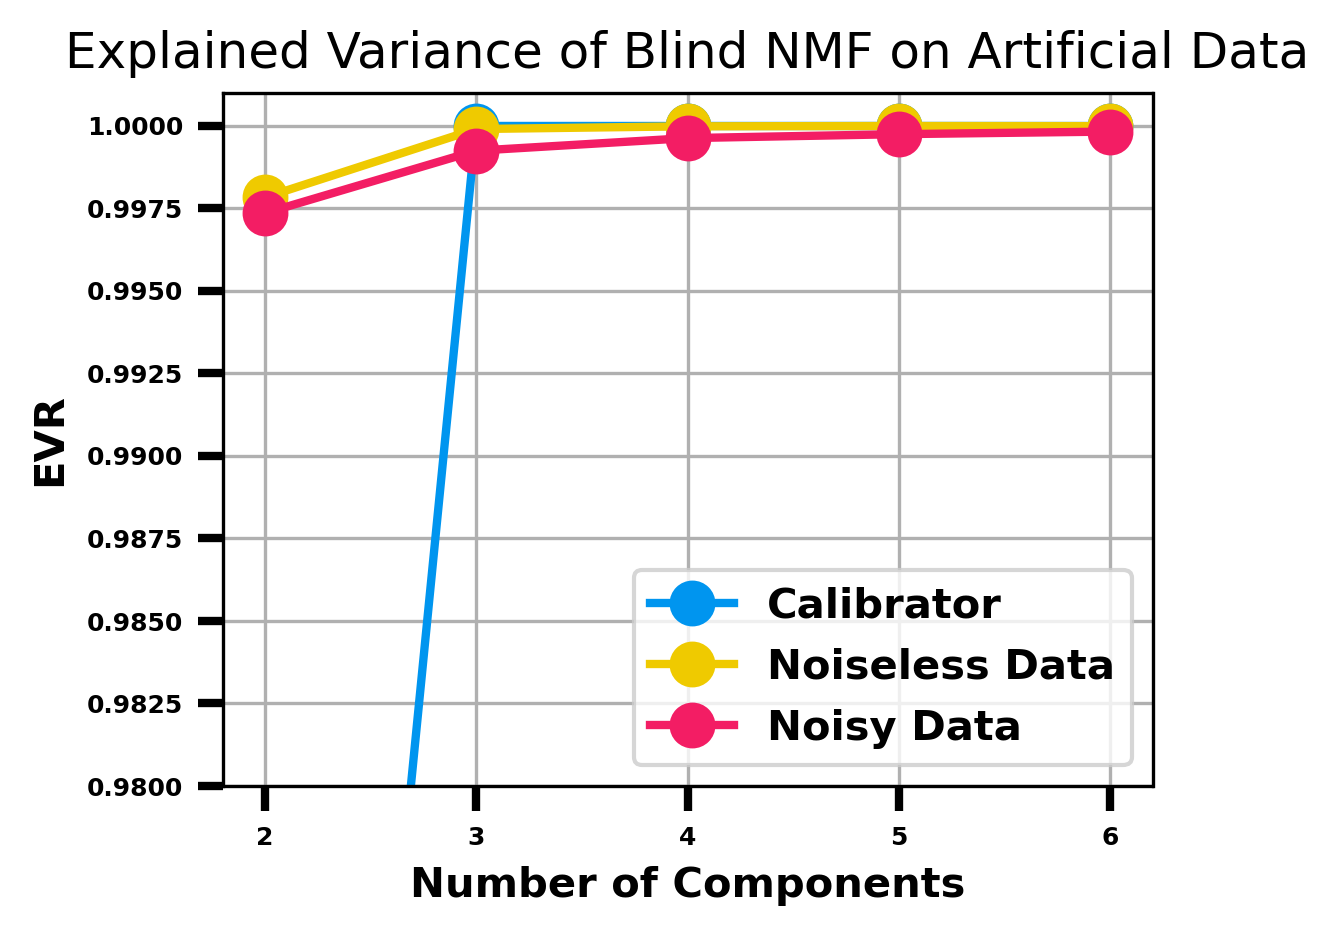

In [176]:
explained_variance_plot("Explained Variance of Blind NMF on Artificial Data", rgb_nmf_results, 
                        hsi1_nmf_results, hsi_nmf_results)

## Sparse NMF with Nimfa

In [ ]:
snmf_n_comp = 3
snmf_iterations = 200
snmf_sparseness_levels = [1e-8, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0]

f0_nimfa_spect_snmf_matrices = []
#f0_nimfa_img_snmf_matrices = []

In [ ]:
for i in snmf_sparseness_levels:
    f0_nimfa_spect_snmf_matrices.append(snmf_model(f0_2d, i, snmf_n_comp, 
                                                   snmf_iterations, 'l'))

In [ ]:
snmf_plot("Sparseness in spectral components\nFigure 0", f0_nimfa_spect_snmf_matrices, 
          snmf_sparseness_levels, snmf_n_comp, f0_xpix, f0_ypix)

# VAE on Artificial Data